In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
!pip install lime==0.2.0.1
!pip install shap==0.35.0
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "sepsis_cases"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = False
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 20

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['sepsis_cases_1']

Bucket 1
Generating distributions for bucket
1 of 147 features
2 of 147 features
3 of 147 features
4 of 147 features
5 of 147 features
6 of 147 features
7 of 147 features
8 of 147 features
9 of 147 features
10 of 147 features
11 of 147 features
12 of 147 features
13 of 147 features
14 of 147 features
15 of 147 features
16 of 147 features
17 of 147 features
18 of 147 features
19 of 147 features
20 of 147 features
21 of 147 features
22 of 147 features
23 of 147 features
24 of 147 features
25 of 147 features
26 of 147 features
27 of 147 features
28 of 147 features
29 of 147 features
30 of 147 features
31 of 147 features
32 of 147 features
33 of 147 features
34 of 147 features
35 of 147 features
36 of 147 features
37 of 147 features
38 of 147 features
39 of 147 features
40 of 147 features
41 of 147 features
42 of 147 features
43 of 147 features
44 of 147 features
45 of 147 features
46 of 147 features
47 of 147 features
48 of 147 features
49 of 147 features
50 of 147 features
51 of 147 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 8 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Cre

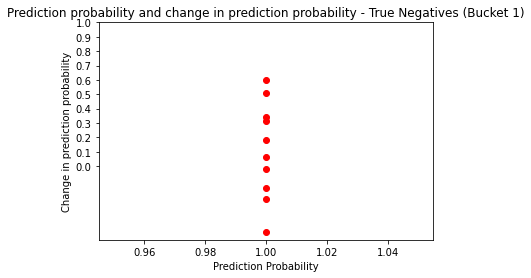

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 5
Creating explanations
Identifying relevant features
Creating dist

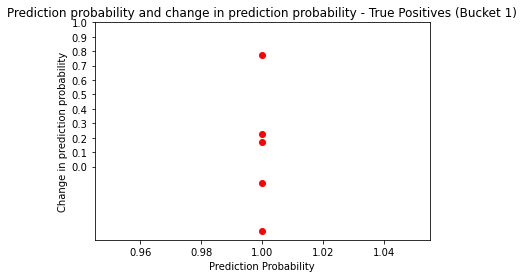

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 5
Creating explanations
Identifying relevant features
Creating dist

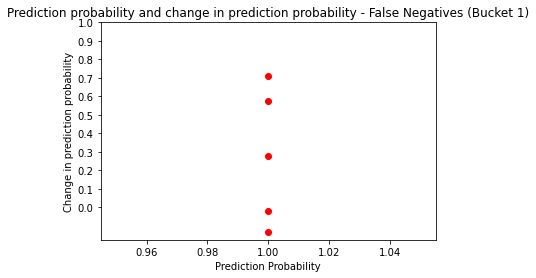

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 9
Creating explanations
Identifying relevant features
Creating dist

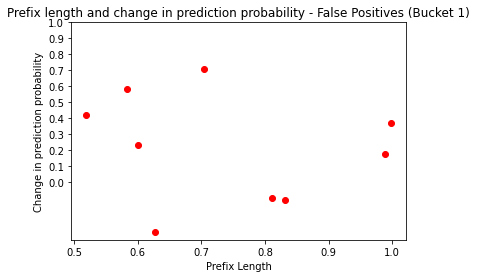

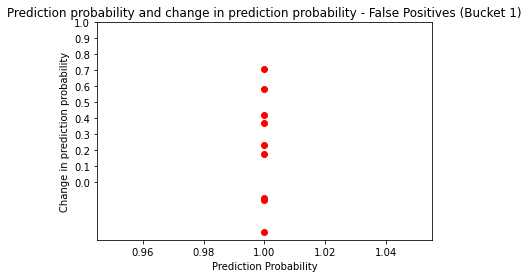

Bucket 2
Generating distributions for bucket
1 of 158 features
2 of 158 features
3 of 158 features
4 of 158 features
5 of 158 features
6 of 158 features
7 of 158 features
8 of 158 features
9 of 158 features
10 of 158 features
11 of 158 features
12 of 158 features
13 of 158 features
14 of 158 features
15 of 158 features
16 of 158 features
17 of 158 features
18 of 158 features
19 of 158 features
20 of 158 features
21 of 158 features
22 of 158 features
23 of 158 features
24 of 158 features
25 of 158 features
26 of 158 features
27 of 158 features
28 of 158 features
29 of 158 features
30 of 158 features
31 of 158 features
32 of 158 features
33 of 158 features
34 of 158 features
35 of 158 features
36 of 158 features
37 of 158 features
38 of 158 features
39 of 158 features
40 of 158 features
41 of 158 features
42 of 158 features
43 of 158 features
44 of 158 features
45 of 158 features
46 of 158 features
47 of 158 features
48 of 158 features
49 of 158 features
50 of 158 features
51 of 158 feat

Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


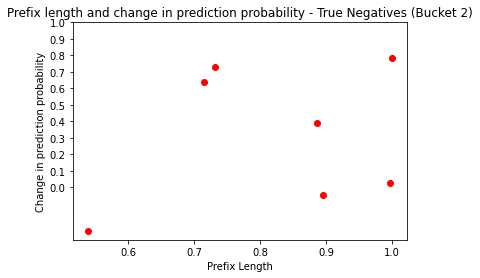

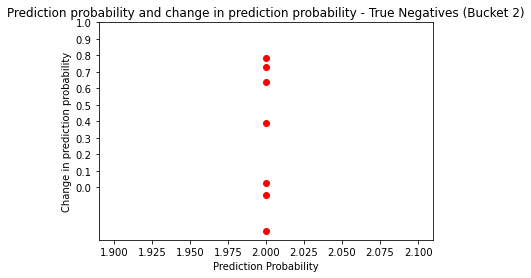

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 3
Creating explanations


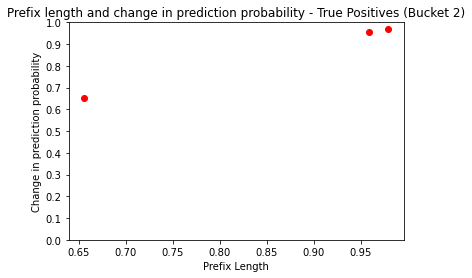

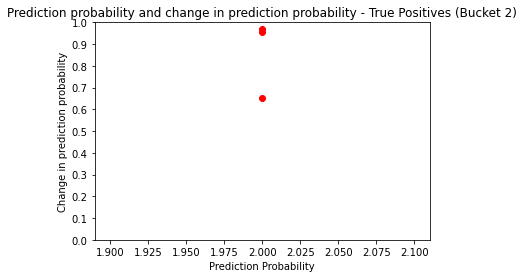

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 3
Creating explanations


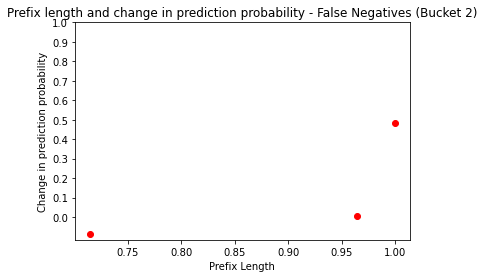

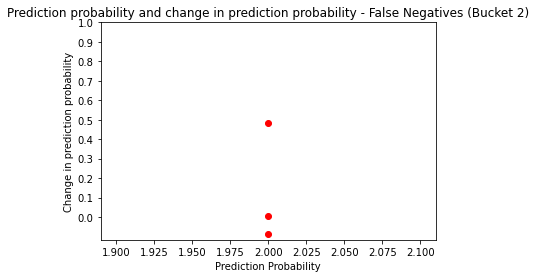

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 16
Creating distribution for feature 2 of 16
Creating distribution for feature 3 of 16
Creating distribution for feature 4 of 16
Creating distribution for feature 5 of 16
Creating distribution for feature 6 of 16
Creating distribution for feature 7 of 16
Creating distribution for feature 8 of 16
Creating distribution for feature 9 of 16
Creating distribution for feature 10 of 16
Creating distribution for feature 11 of 16
Creating distribution for feature 12 of 16
Creating distribution for feature 13 of 16
Creating distribution for feature 14 of 16
Creating distribution for feature 15 of 16
Creating distribution for feature 16 of 16
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 9
Creating explanations


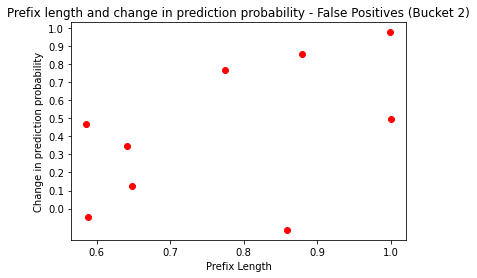

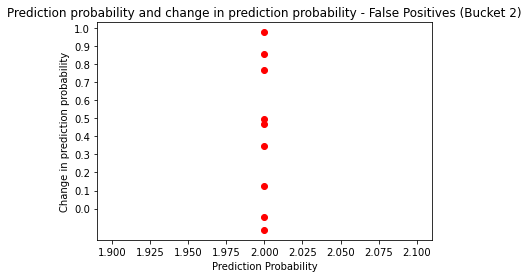

Bucket 3
Generating distributions for bucket
1 of 188 features
2 of 188 features
3 of 188 features
4 of 188 features
5 of 188 features
6 of 188 features
7 of 188 features
8 of 188 features
9 of 188 features
10 of 188 features
11 of 188 features
12 of 188 features
13 of 188 features
14 of 188 features
15 of 188 features
16 of 188 features
17 of 188 features
18 of 188 features
19 of 188 features
20 of 188 features
21 of 188 features
22 of 188 features
23 of 188 features
24 of 188 features
25 of 188 features
26 of 188 features
27 of 188 features
28 of 188 features
29 of 188 features
30 of 188 features
31 of 188 features
32 of 188 features
33 of 188 features
34 of 188 features
35 of 188 features
36 of 188 features
37 of 188 features
38 of 188 features
39 of 188 features
40 of 188 features
41 of 188 features
42 of 188 features
43 of 188 features
44 of 188 features
45 of 188 features
46 of 188 features
47 of 188 features
48 of 188 features
49 of 188 features
50 of 188 features
51 of 188 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

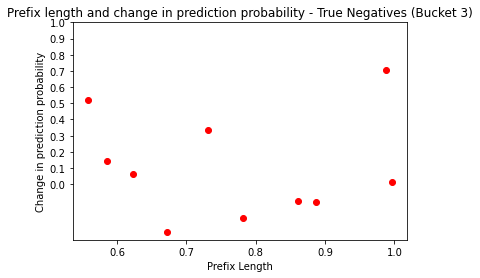

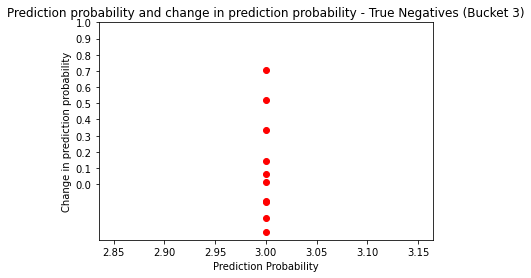

Category 2 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

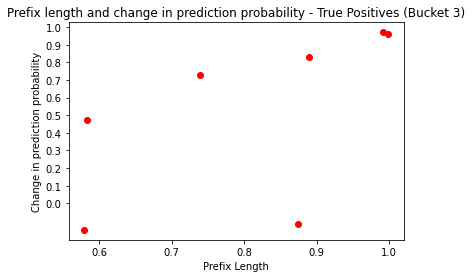

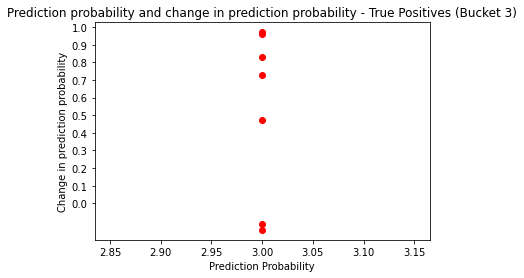

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6

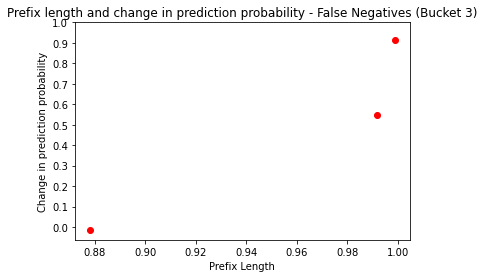

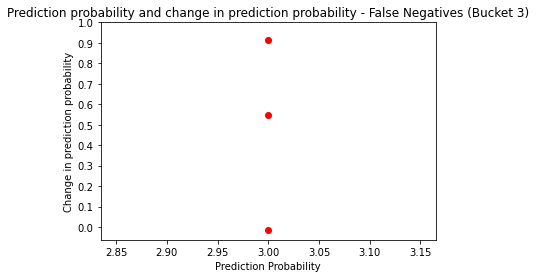

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 19
Creating distribution for feature 2 of 19
Creating distribution for feature 3 of 19
Creating distribution for feature 4 of 19
Creating distribution for feature 5 of 19
Creating distribution for feature 6 of 19
Creating distribution for feature 7 of 19
Creating distribution for feature 8 of 19
Creating distribution for feature 9 of 19
Creating distribution for feature 10 of 19
Creating distribution for feature 11 of 19
Creating distribution for feature 12 of 19
Creating distribution for feature 13 of 19
Creating distribution for feature 14 of 19
Creating distribution for feature 15 of 19
Creating distribution for feature 16 of 19
Creating distribution for feature 17 of 19
Creating distribution for feature 18 of 19
Creating distribution for feature 19 of 19
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Ru

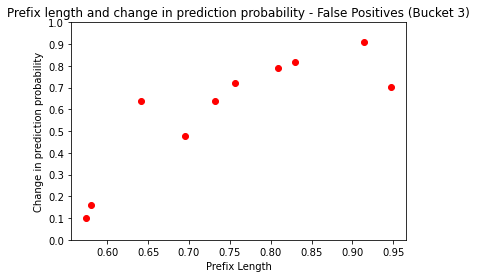

Bucket 4
Generating distributions for bucket
1 of 206 features
2 of 206 features
3 of 206 features
4 of 206 features
5 of 206 features
6 of 206 features
7 of 206 features
8 of 206 features
9 of 206 features
10 of 206 features
11 of 206 features
12 of 206 features
13 of 206 features
14 of 206 features
15 of 206 features
16 of 206 features
17 of 206 features
18 of 206 features
19 of 206 features
20 of 206 features
21 of 206 features
22 of 206 features
23 of 206 features
24 of 206 features
25 of 206 features
26 of 206 features
27 of 206 features
28 of 206 features
29 of 206 features
30 of 206 features
31 of 206 features
32 of 206 features
33 of 206 features
34 of 206 features
35 of 206 features
36 of 206 features
37 of 206 features
38 of 206 features
39 of 206 features
40 of 206 features
41 of 206 features
42 of 206 features
43 of 206 features
44 of 206 features
45 of 206 features
46 of 206 features
47 of 206 features
48 of 206 features
49 of 206 features
50 of 206 features
51 of 206 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


Category 2 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

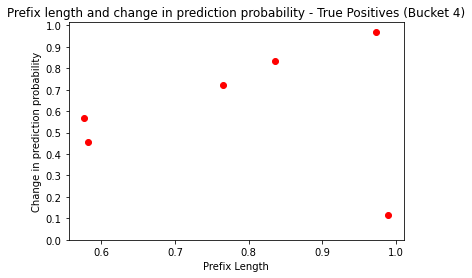

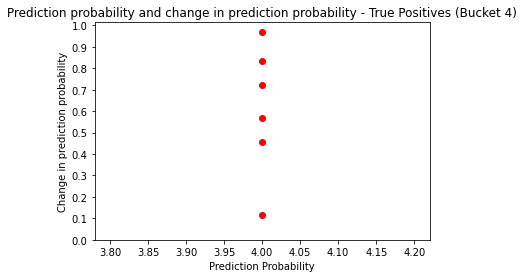

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Per

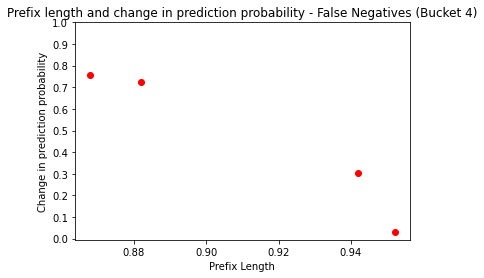

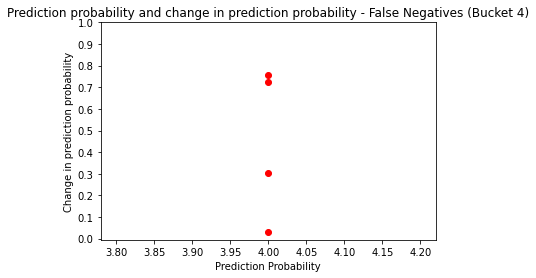

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


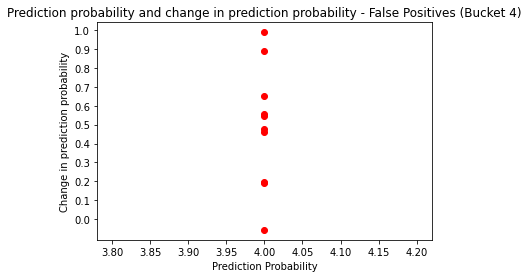

Bucket 5
Generating distributions for bucket
1 of 236 features
2 of 236 features
3 of 236 features
4 of 236 features
5 of 236 features
6 of 236 features
7 of 236 features
8 of 236 features
9 of 236 features
10 of 236 features
11 of 236 features
12 of 236 features
13 of 236 features
14 of 236 features
15 of 236 features
16 of 236 features
17 of 236 features
18 of 236 features
19 of 236 features
20 of 236 features
21 of 236 features
22 of 236 features
23 of 236 features
24 of 236 features
25 of 236 features
26 of 236 features
27 of 236 features
28 of 236 features
29 of 236 features
30 of 236 features
31 of 236 features
32 of 236 features
33 of 236 features
34 of 236 features
35 of 236 features
36 of 236 features
37 of 236 features
38 of 236 features
39 of 236 features
40 of 236 features
41 of 236 features
42 of 236 features
43 of 236 features
44 of 236 features
45 of 236 features
46 of 236 features
47 of 236 features
48 of 236 features
49 of 236 features
50 of 236 features
51 of 236 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 24
Creating distribution for feature 2 of 24
Creating distribution for feature 3 of 24
Creating distribution for feature 4 of 24
Creating distribution for feature 5 of 24
Creating distribution for feature 6 of 24
Creating distribution for feature 7 of 24
Creating distribution for feature 8 of 24
Creating distribution for feature 9 of 24
Creating distribution for feature 10 of 24
Creating distribution for feature 11 of 24
Creating distribution for feature 12 of 24
Creating distribution for feature 13 of 24
Creating distribution for feature 14 of 24
Creating distribution for feature 15 of 24
Creating distribution for feature 16 of 24
Creating distribution for feature 17 of 24
Creating distribution for feature 18 of 24
Creating distribution for feature 19 of 24
Creating distribution for feature 20 of 24
Creating distribution for feature 21 of 24
Creating distribution for feature 22 of 24
Creating di

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 24
Creating distribution for feature 2 of 24
Creating distribution for feature 3 of 24
Creating distribution for feature 4 of 24
Creating distribution for feature 5 of 24
Creating distribution for feature 6 of 24
Creating distribution for feature 7 of 24
Creating distribution for feature 8 of 24
Creating distribution for feature 9 of 24
Creating distribution for feature 10 of 24
Creating distribution for feature 11 of 24
Creating distribution for feature 12 of 24
Creating distribution for feature 13 of 24
Creating distribution for feature 14 of 24
Creating distribution for feature 15 of 24
Creating distribution for feature 16 of 24
Creating distribution for feature 17 of 24
Creating distribution for feature 18 of 24
Creating distribution for feature 19 of 24
Creating distribution for feature 20 of 24
Creating distribution for feature 21 of 24
Creating distribution

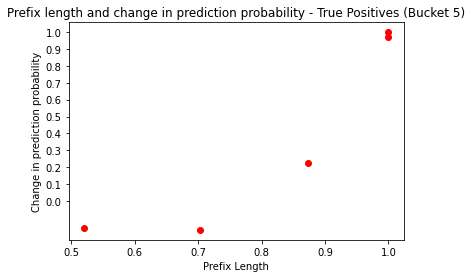

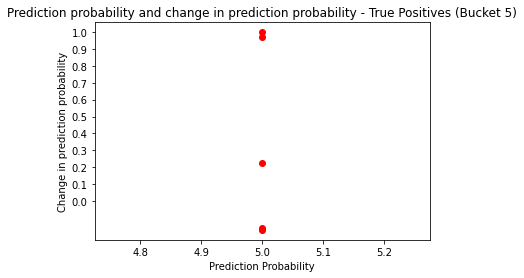

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 24
Creating distribution for feature 2 of 24
Creating distribution for feature 3 of 24
Creating distribution for feature 4 of 24
Creating distribution for feature 5 of 24
Creating distribution for feature 6 of 24
Creating distribution for feature 7 of 24
Creating distribution for feature 8 of 24
Creating distribution for feature 9 of 24
Creating distribution for feature 10 of 24
Creating distribution for feature 11 of 24
Creating distribution for feature 12 of 24
Creating distribution for feature 13 of 24
Creating distribution for feature 14 of 24
Creating distribution for feature 15 of 24
Creating distribution for feature 16 of 24
Creating distribution for feature 17 of 24
Creating distribution for feature 18 of 24
Creating distribution for feature 19 of 24
Creating distribution for feature 20 of 24
Creating distribution for feature 21 of 24
Creating distribution

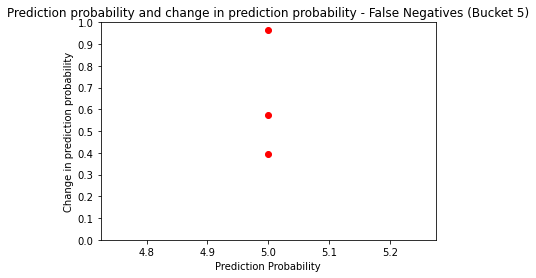

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 24
Creating distribution for feature 2 of 24
Creating distribution for feature 3 of 24
Creating distribution for feature 4 of 24
Creating distribution for feature 5 of 24
Creating distribution for feature 6 of 24
Creating distribution for feature 7 of 24
Creating distribution for feature 8 of 24
Creating distribution for feature 9 of 24
Creating distribution for feature 10 of 24
Creating distribution for feature 11 of 24
Creating distribution for feature 12 of 24
Creating distribution for feature 13 of 24
Creating distribution for feature 14 of 24
Creating distribution for feature 15 of 24
Creating distribution for feature 16 of 24
Creating distribution for feature 17 of 24
Creating distribution for feature 18 of 24
Creating distribution for feature 19 of 24
Creating distribution for feature 20 of 24
Creating distribution for feature 21 of 24
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 24
Creating distribution for feature 2 of 24
Creating distribution for feature 3 of 24
Creating distribution for feature 4 of 24
Creating distribution for feature 5 of 24
Creating distribution for feature 6 of 24
Creating distribution for feature 7 of 24
Creating distribution for feature 8 of 24
Creating distribution for feature 9 of 24
Creating distribution for feature 10 of 24
Creating distribution for feature 11 of 24
Creating distribution for feature 12 of 24
Creating distribution for feature 13 of 24
Creating distribution for feature 14 of 24
Creating distribution for feature 15 of 24
Creating distribution for feature 16 of 24
Creating distribution for feature 17 of 24
Creating distribution for feature 18 of 24
Creating distribution for feature 19 of 24
Creating distribution for feature 20 of 24
Creating distribution for feature 21 of 24
Creating distribution for feature 22 of 24
Creating di

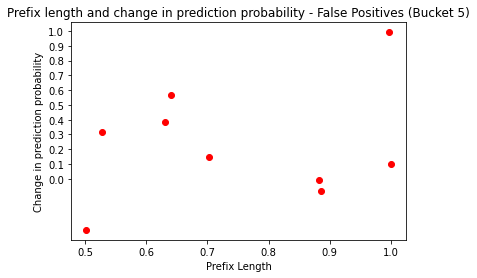

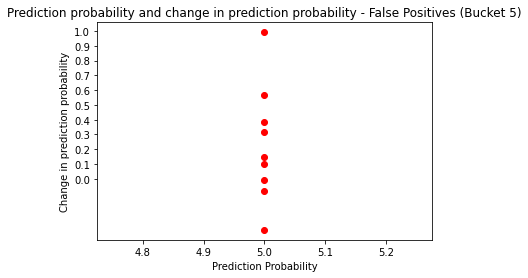

Bucket 6
Generating distributions for bucket
1 of 262 features
2 of 262 features
3 of 262 features
4 of 262 features
5 of 262 features
6 of 262 features
7 of 262 features
8 of 262 features
9 of 262 features
10 of 262 features
11 of 262 features
12 of 262 features
13 of 262 features
14 of 262 features
15 of 262 features
16 of 262 features
17 of 262 features
18 of 262 features
19 of 262 features
20 of 262 features
21 of 262 features
22 of 262 features
23 of 262 features
24 of 262 features
25 of 262 features
26 of 262 features
27 of 262 features
28 of 262 features
29 of 262 features
30 of 262 features
31 of 262 features
32 of 262 features
33 of 262 features
34 of 262 features
35 of 262 features
36 of 262 features
37 of 262 features
38 of 262 features
39 of 262 features
40 of 262 features
41 of 262 features
42 of 262 features
43 of 262 features
44 of 262 features
45 of 262 features
46 of 262 features
47 of 262 features
48 of 262 features
49 of 262 features
50 of 262 features
51 of 262 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 26
Creating distribution for feature 2 of 26
Creating distribution for feature 3 of 26
Creating distribution for feature 4 of 26
Creating distribution for feature 5 of 26
Creating distribution for feature 6 of 26
Creating distribution for feature 7 of 26
Creating distribution for feature 8 of 26
Creating distribution for feature 9 of 26
Creating distribution for feature 10 of 26
Creating distribution for feature 11 of 26
Creating distribution for feature 12 of 26
Creating distribution for feature 13 of 26
Creating distribution for feature 14 of 26
Creating distribution for feature 15 of 26
Creating distribution for feature 16 of 26
Creating distribution for feature 17 of 26
Creating distribution for feature 18 of 26
Creating distribution for feature 19 of 26
Creating distribution for feature 20 of 26
Creating distribution for feature 21 of 26
Creating distribution for feature 22 of 26
Creating di

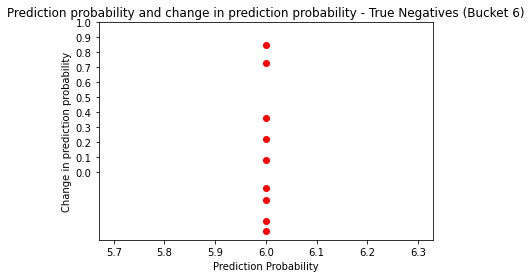

Category 2 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 26
Creating distribution for feature 2 of 26
Creating distribution for feature 3 of 26
Creating distribution for feature 4 of 26
Creating distribution for feature 5 of 26
Creating distribution for feature 6 of 26
Creating distribution for feature 7 of 26
Creating distribution for feature 8 of 26
Creating distribution for feature 9 of 26
Creating distribution for feature 10 of 26
Creating distribution for feature 11 of 26
Creating distribution for feature 12 of 26
Creating distribution for feature 13 of 26
Creating distribution for feature 14 of 26
Creating distribution for feature 15 of 26
Creating distribution for feature 16 of 26
Creating distribution for feature 17 of 26
Creating distribution for feature 18 of 26
Creating distribution for feature 19 of 26
Creating distribution for feature 20 of 26
Creating distribution for feature 21 of 26
Creating distribution

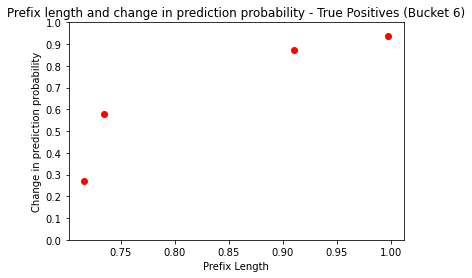

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 26
Creating distribution for feature 2 of 26
Creating distribution for feature 3 of 26
Creating distribution for feature 4 of 26
Creating distribution for feature 5 of 26
Creating distribution for feature 6 of 26
Creating distribution for feature 7 of 26
Creating distribution for feature 8 of 26
Creating distribution for feature 9 of 26
Creating distribution for feature 10 of 26
Creating distribution for feature 11 of 26
Creating distribution for feature 12 of 26
Creating distribution for feature 13 of 26
Creating distribution for feature 14 of 26
Creating distribution for feature 15 of 26
Creating distribution for feature 16 of 26
Creating distribution for feature 17 of 26
Creating distribution for feature 18 of 26
Creating distribution for feature 19 of 26
Creating distribution for feature 20 of 26
Creating distribution for feature 21 of 26
Creating distribution

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 26
Creating distribution for feature 2 of 26
Creating distribution for feature 3 of 26
Creating distribution for feature 4 of 26
Creating distribution for feature 5 of 26
Creating distribution for feature 6 of 26
Creating distribution for feature 7 of 26
Creating distribution for feature 8 of 26
Creating distribution for feature 9 of 26
Creating distribution for feature 10 of 26
Creating distribution for feature 11 of 26
Creating distribution for feature 12 of 26
Creating distribution for feature 13 of 26
Creating distribution for feature 14 of 26
Creating distribution for feature 15 of 26
Creating distribution for feature 16 of 26
Creating distribution for feature 17 of 26
Creating distribution for feature 18 of 26
Creating distribution for feature 19 of 26
Creating distribution for feature 20 of 26
Creating distribution for feature 21 of 26
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 26
Creating distribution for feature 2 of 26
Creating distribution for feature 3 of 26
Creating distribution for feature 4 of 26
Creating distribution for feature 5 of 26
Creating distribution for feature 6 of 26
Creating distribution for feature 7 of 26
Creating distribution for feature 8 of 26
Creating distribution for feature 9 of 26
Creating distribution for feature 10 of 26
Creating distribution for feature 11 of 26
Creating distribution for feature 12 of 26
Creating distribution for feature 13 of 26
Creating distribution for feature 14 of 26
Creating distribution for feature 15 of 26
Creating distribution for feature 16 of 26
Creating distribution for feature 17 of 26
Creating distribution for feature 18 of 26
Creating distribution for feature 19 of 26
Creating distribution for feature 20 of 26
Creating distribution for feature 21 of 26
Creating distribution for feature 22 of 26
Creating di

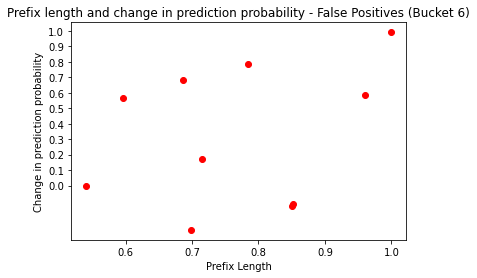

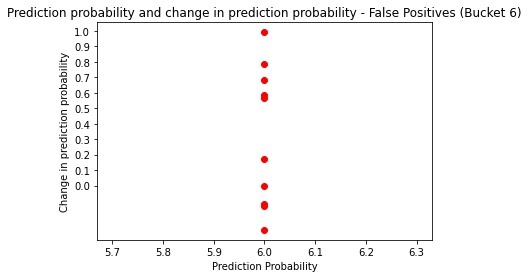

Bucket 7
Generating distributions for bucket
1 of 289 features
2 of 289 features
3 of 289 features
4 of 289 features
5 of 289 features
6 of 289 features
7 of 289 features
8 of 289 features
9 of 289 features
10 of 289 features
11 of 289 features
12 of 289 features
13 of 289 features
14 of 289 features
15 of 289 features
16 of 289 features
17 of 289 features
18 of 289 features
19 of 289 features
20 of 289 features
21 of 289 features
22 of 289 features
23 of 289 features
24 of 289 features
25 of 289 features
26 of 289 features
27 of 289 features
28 of 289 features
29 of 289 features
30 of 289 features
31 of 289 features
32 of 289 features
33 of 289 features
34 of 289 features
35 of 289 features
36 of 289 features
37 of 289 features
38 of 289 features
39 of 289 features
40 of 289 features
41 of 289 features
42 of 289 features
43 of 289 features
44 of 289 features
45 of 289 features
46 of 289 features
47 of 289 features
48 of 289 features
49 of 289 features
50 of 289 features
51 of 289 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution for feature 22 of 29
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution for feature 22 of 29
Creating di

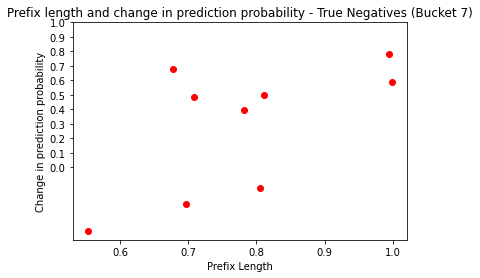

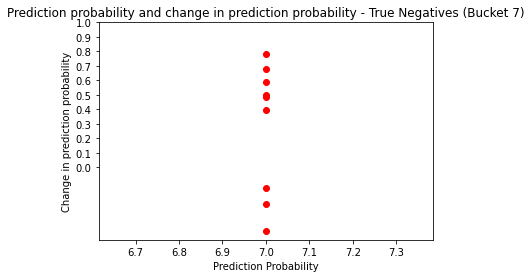

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution

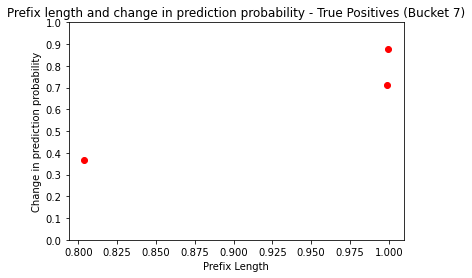

Category 3 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution

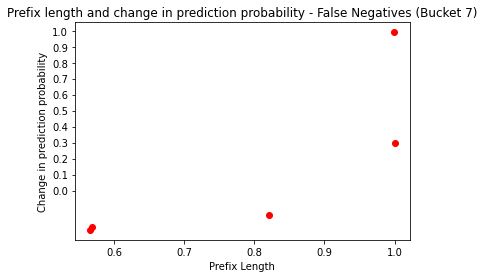

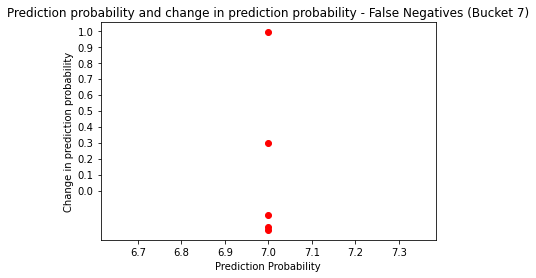

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 29
Creating distribution for feature 2 of 29
Creating distribution for feature 3 of 29
Creating distribution for feature 4 of 29
Creating distribution for feature 5 of 29
Creating distribution for feature 6 of 29
Creating distribution for feature 7 of 29
Creating distribution for feature 8 of 29
Creating distribution for feature 9 of 29
Creating distribution for feature 10 of 29
Creating distribution for feature 11 of 29
Creating distribution for feature 12 of 29
Creating distribution for feature 13 of 29
Creating distribution for feature 14 of 29
Creating distribution for feature 15 of 29
Creating distribution for feature 16 of 29
Creating distribution for feature 17 of 29
Creating distribution for feature 18 of 29
Creating distribution for feature 19 of 29
Creating distribution for feature 20 of 29
Creating distribution for feature 21 of 29
Creating distribution for feature 22 of 29
Creating di

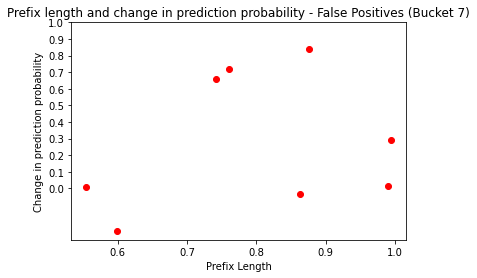

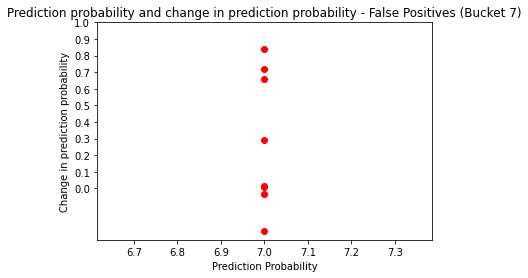

Bucket 8
Generating distributions for bucket
1 of 320 features
2 of 320 features
3 of 320 features
4 of 320 features
5 of 320 features
6 of 320 features
7 of 320 features
8 of 320 features
9 of 320 features
10 of 320 features
11 of 320 features
12 of 320 features
13 of 320 features
14 of 320 features
15 of 320 features
16 of 320 features
17 of 320 features
18 of 320 features
19 of 320 features
20 of 320 features
21 of 320 features
22 of 320 features
23 of 320 features
24 of 320 features
25 of 320 features
26 of 320 features
27 of 320 features
28 of 320 features
29 of 320 features
30 of 320 features
31 of 320 features
32 of 320 features
33 of 320 features
34 of 320 features
35 of 320 features
36 of 320 features
37 of 320 features
38 of 320 features
39 of 320 features
40 of 320 features
41 of 320 features
42 of 320 features
43 of 320 features
44 of 320 features
45 of 320 features
46 of 320 features
47 of 320 features
48 of 320 features
49 of 320 features
50 of 320 features
51 of 320 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

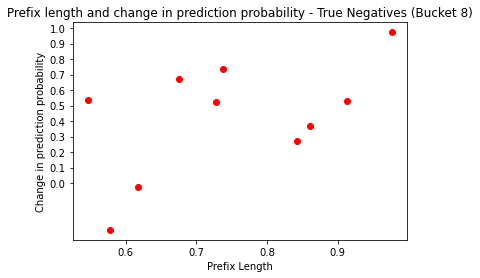

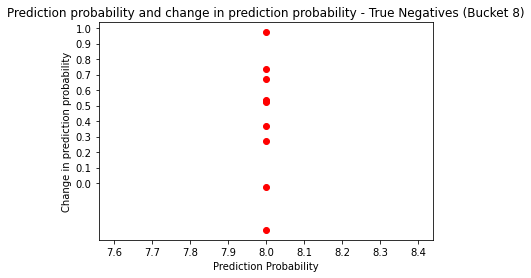

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution

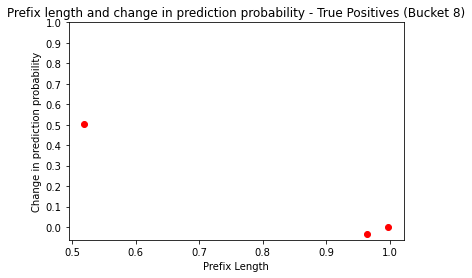

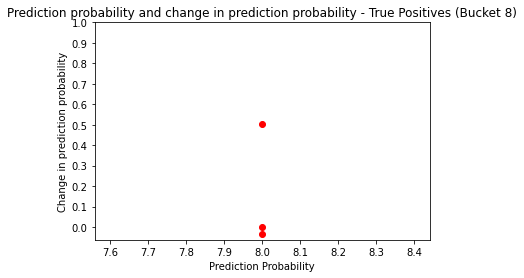

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution

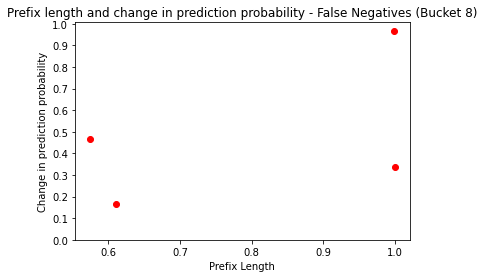

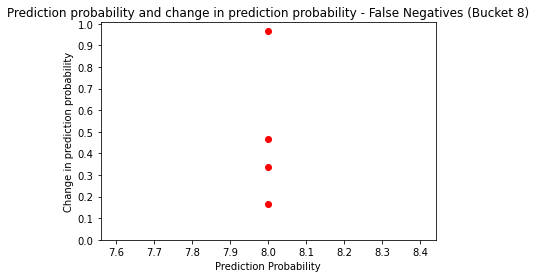

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 32
Creating distribution for feature 2 of 32
Creating distribution for feature 3 of 32
Creating distribution for feature 4 of 32
Creating distribution for feature 5 of 32
Creating distribution for feature 6 of 32
Creating distribution for feature 7 of 32
Creating distribution for feature 8 of 32
Creating distribution for feature 9 of 32
Creating distribution for feature 10 of 32
Creating distribution for feature 11 of 32
Creating distribution for feature 12 of 32
Creating distribution for feature 13 of 32
Creating distribution for feature 14 of 32
Creating distribution for feature 15 of 32
Creating distribution for feature 16 of 32
Creating distribution for feature 17 of 32
Creating distribution for feature 18 of 32
Creating distribution for feature 19 of 32
Creating distribution for feature 20 of 32
Creating distribution for feature 21 of 32
Creating distribution for feature 22 of 32
Creating di

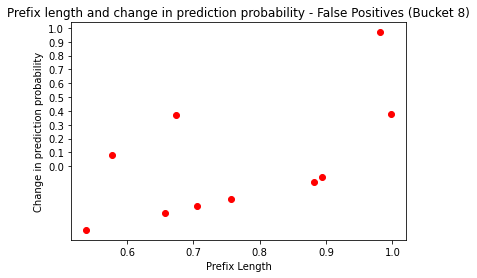

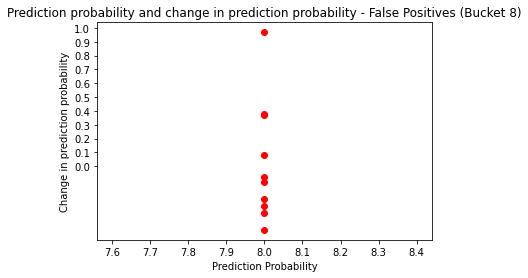

Bucket 9
Generating distributions for bucket
1 of 358 features
2 of 358 features
3 of 358 features
4 of 358 features
5 of 358 features
6 of 358 features
7 of 358 features
8 of 358 features
9 of 358 features
10 of 358 features
11 of 358 features
12 of 358 features
13 of 358 features
14 of 358 features
15 of 358 features
16 of 358 features
17 of 358 features
18 of 358 features
19 of 358 features
20 of 358 features
21 of 358 features
22 of 358 features
23 of 358 features
24 of 358 features
25 of 358 features
26 of 358 features
27 of 358 features
28 of 358 features
29 of 358 features
30 of 358 features
31 of 358 features
32 of 358 features
33 of 358 features
34 of 358 features
35 of 358 features
36 of 358 features
37 of 358 features
38 of 358 features
39 of 358 features
40 of 358 features
41 of 358 features
42 of 358 features
43 of 358 features
44 of 358 features
45 of 358 features
46 of 358 features
47 of 358 features
48 of 358 features
49 of 358 features
50 of 358 features
51 of 358 feat

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distribution for feature 22 of 36
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distribution for feature 22 of 36
Creating di

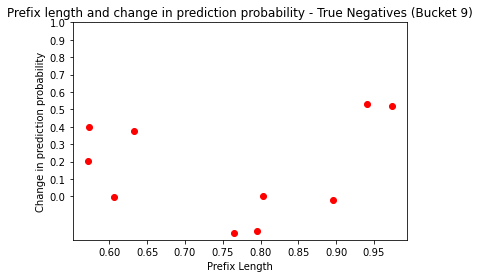

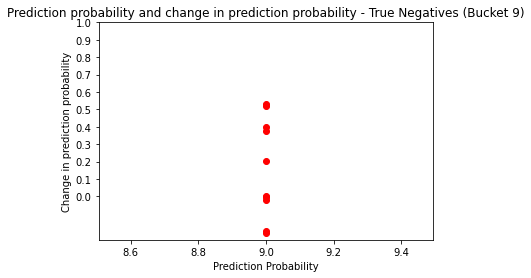

Category 2 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distribution

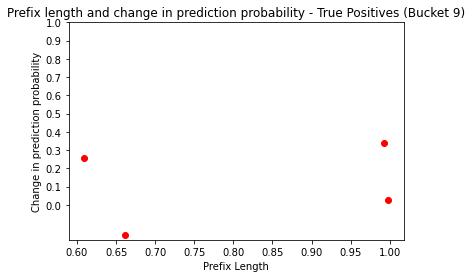

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distribution

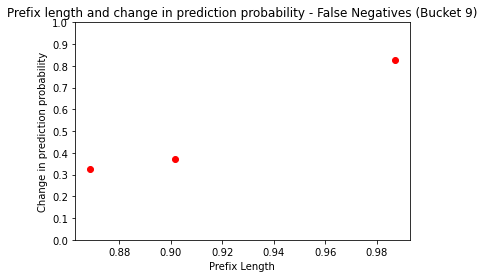

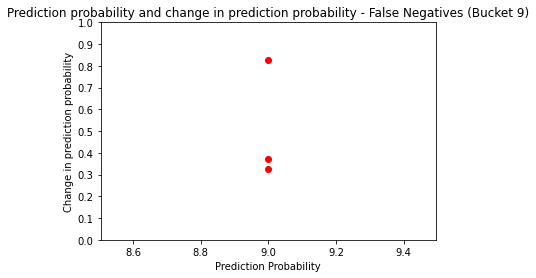

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 36
Creating distribution for feature 2 of 36
Creating distribution for feature 3 of 36
Creating distribution for feature 4 of 36
Creating distribution for feature 5 of 36
Creating distribution for feature 6 of 36
Creating distribution for feature 7 of 36
Creating distribution for feature 8 of 36
Creating distribution for feature 9 of 36
Creating distribution for feature 10 of 36
Creating distribution for feature 11 of 36
Creating distribution for feature 12 of 36
Creating distribution for feature 13 of 36
Creating distribution for feature 14 of 36
Creating distribution for feature 15 of 36
Creating distribution for feature 16 of 36
Creating distribution for feature 17 of 36
Creating distribution for feature 18 of 36
Creating distribution for feature 19 of 36
Creating distribution for feature 20 of 36
Creating distribution for feature 21 of 36
Creating distribution for feature 22 of 36
Creating di

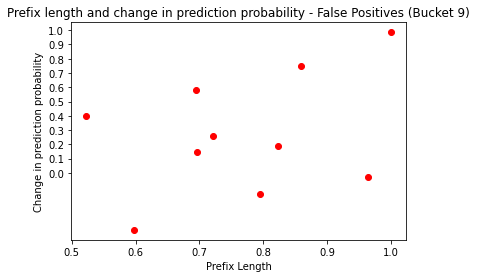

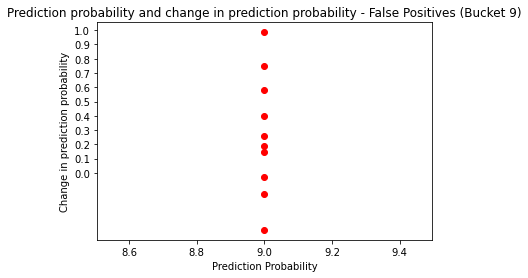

Bucket 10
Generating distributions for bucket
1 of 386 features
2 of 386 features
3 of 386 features
4 of 386 features
5 of 386 features
6 of 386 features
7 of 386 features
8 of 386 features
9 of 386 features
10 of 386 features
11 of 386 features
12 of 386 features
13 of 386 features
14 of 386 features
15 of 386 features
16 of 386 features
17 of 386 features
18 of 386 features
19 of 386 features
20 of 386 features
21 of 386 features
22 of 386 features
23 of 386 features
24 of 386 features
25 of 386 features
26 of 386 features
27 of 386 features
28 of 386 features
29 of 386 features
30 of 386 features
31 of 386 features
32 of 386 features
33 of 386 features
34 of 386 features
35 of 386 features
36 of 386 features
37 of 386 features
38 of 386 features
39 of 386 features
40 of 386 features
41 of 386 features
42 of 386 features
43 of 386 features
44 of 386 features
45 of 386 features
46 of 386 features
47 of 386 features
48 of 386 features
49 of 386 features
50 of 386 features
51 of 386 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution for feature 22 of 39
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution for feature 22 of 39
Creating di

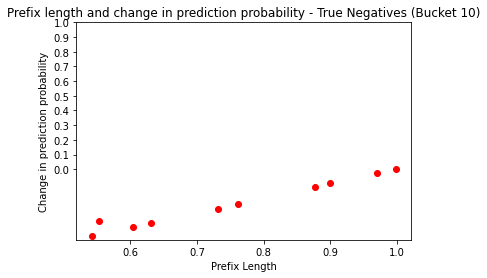

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution

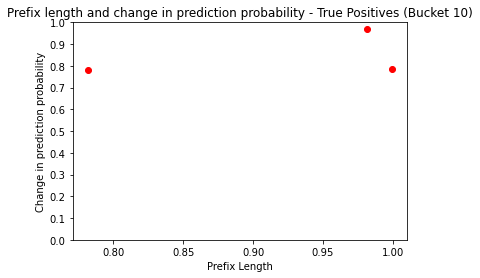

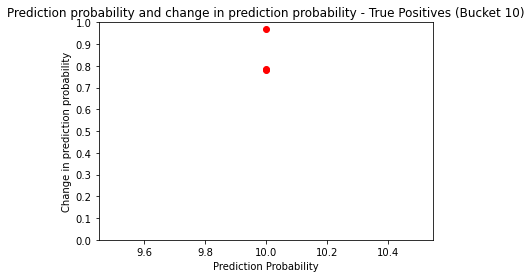

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution

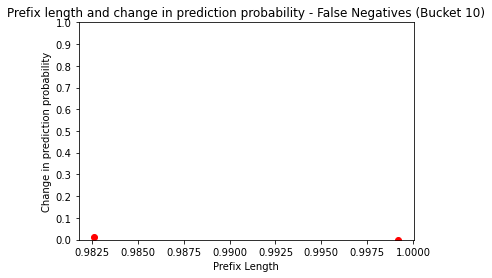

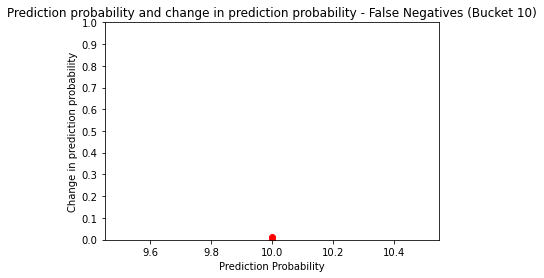

Category 4 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 39
Creating distribution for feature 2 of 39
Creating distribution for feature 3 of 39
Creating distribution for feature 4 of 39
Creating distribution for feature 5 of 39
Creating distribution for feature 6 of 39
Creating distribution for feature 7 of 39
Creating distribution for feature 8 of 39
Creating distribution for feature 9 of 39
Creating distribution for feature 10 of 39
Creating distribution for feature 11 of 39
Creating distribution for feature 12 of 39
Creating distribution for feature 13 of 39
Creating distribution for feature 14 of 39
Creating distribution for feature 15 of 39
Creating distribution for feature 16 of 39
Creating distribution for feature 17 of 39
Creating distribution for feature 18 of 39
Creating distribution for feature 19 of 39
Creating distribution for feature 20 of 39
Creating distribution for feature 21 of 39
Creating distribution for feature 22 of 39
Creating di

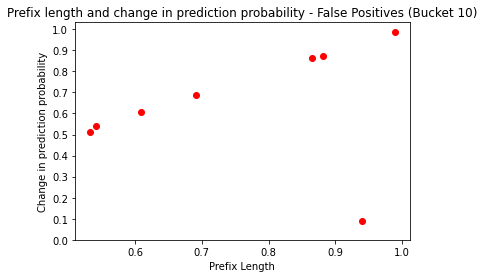

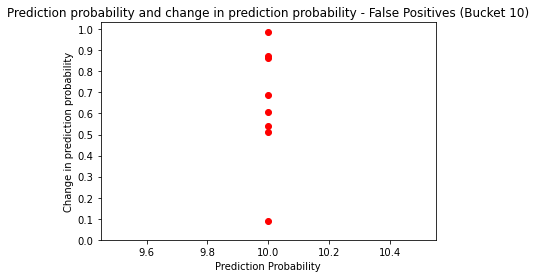

Bucket 11
Generating distributions for bucket
1 of 417 features
2 of 417 features
3 of 417 features
4 of 417 features
5 of 417 features
6 of 417 features
7 of 417 features
8 of 417 features
9 of 417 features
10 of 417 features
11 of 417 features
12 of 417 features
13 of 417 features
14 of 417 features
15 of 417 features
16 of 417 features
17 of 417 features
18 of 417 features
19 of 417 features
20 of 417 features
21 of 417 features
22 of 417 features
23 of 417 features
24 of 417 features
25 of 417 features
26 of 417 features
27 of 417 features
28 of 417 features
29 of 417 features
30 of 417 features
31 of 417 features
32 of 417 features
33 of 417 features
34 of 417 features
35 of 417 features
36 of 417 features
37 of 417 features
38 of 417 features
39 of 417 features
40 of 417 features
41 of 417 features
42 of 417 features
43 of 417 features
44 of 417 features
45 of 417 features
46 of 417 features
47 of 417 features
48 of 417 features
49 of 417 features
50 of 417 features
51 of 417 fea

Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution for feature 22 of 42
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution for feature 22 of 42
Creating di

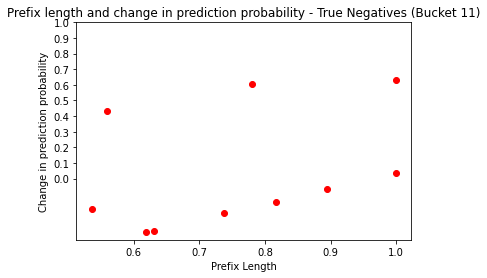

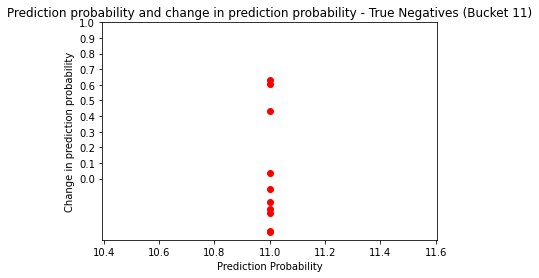

Category 2 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution for feature 22 of 42
Creating di

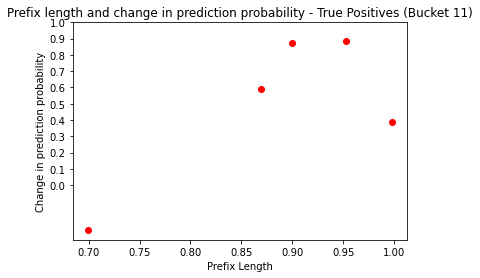

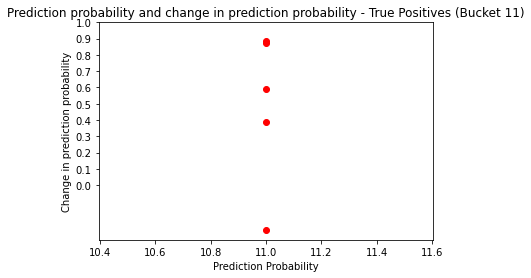

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution

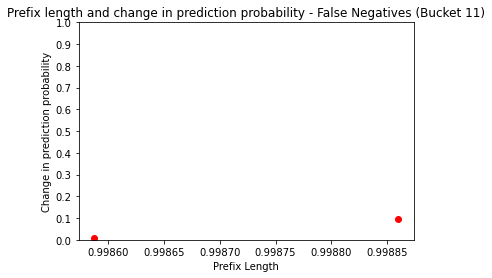

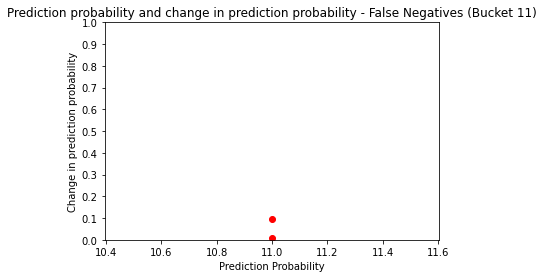

Category 4 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution for feature 22 of 42
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 42
Creating distribution for feature 2 of 42
Creating distribution for feature 3 of 42
Creating distribution for feature 4 of 42
Creating distribution for feature 5 of 42
Creating distribution for feature 6 of 42
Creating distribution for feature 7 of 42
Creating distribution for feature 8 of 42
Creating distribution for feature 9 of 42
Creating distribution for feature 10 of 42
Creating distribution for feature 11 of 42
Creating distribution for feature 12 of 42
Creating distribution for feature 13 of 42
Creating distribution for feature 14 of 42
Creating distribution for feature 15 of 42
Creating distribution for feature 16 of 42
Creating distribution for feature 17 of 42
Creating distribution for feature 18 of 42
Creating distribution for feature 19 of 42
Creating distribution for feature 20 of 42
Creating distribution for feature 21 of 42
Creating distribution for feature 22 of 42
Creating di

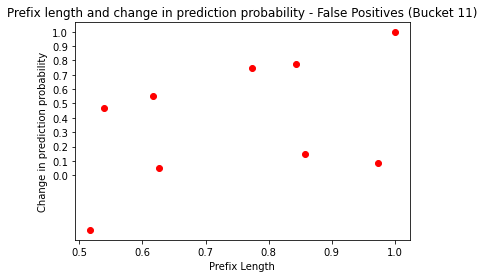

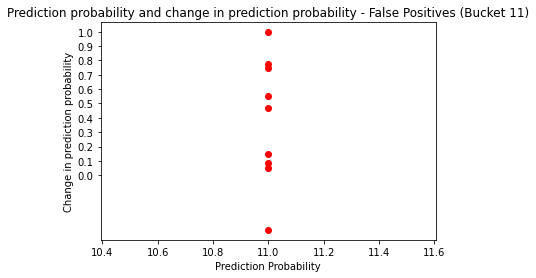

Bucket 12
Generating distributions for bucket
1 of 435 features
2 of 435 features
3 of 435 features
4 of 435 features
5 of 435 features
6 of 435 features
7 of 435 features
8 of 435 features
9 of 435 features
10 of 435 features
11 of 435 features
12 of 435 features
13 of 435 features
14 of 435 features
15 of 435 features
16 of 435 features
17 of 435 features
18 of 435 features
19 of 435 features
20 of 435 features
21 of 435 features
22 of 435 features
23 of 435 features
24 of 435 features
25 of 435 features
26 of 435 features
27 of 435 features
28 of 435 features
29 of 435 features
30 of 435 features
31 of 435 features
32 of 435 features
33 of 435 features
34 of 435 features
35 of 435 features
36 of 435 features
37 of 435 features
38 of 435 features
39 of 435 features
40 of 435 features
41 of 435 features
42 of 435 features
43 of 435 features
44 of 435 features
45 of 435 features
46 of 435 features
47 of 435 features
48 of 435 features
49 of 435 features
50 of 435 features
51 of 435 fea

419 of 435 features
420 of 435 features
421 of 435 features
422 of 435 features
423 of 435 features
424 of 435 features
425 of 435 features
426 of 435 features
427 of 435 features
428 of 435 features
429 of 435 features
430 of 435 features
431 of 435 features
432 of 435 features
433 of 435 features
434 of 435 features
435 of 435 features
Category 1 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for feature 14 of 44
Creating distribution for feature 15 of 44
Creating distribution for feature 16 of 44
Creating distribution for feature 17 of 44
Creating distribution for feature 18 of 44
Creating distribution for feature 19 of 44
Creating distribution for feature 20 of 44
Creating distribution for feature 21 of 44
Creating distribution for feature 22 of 44
Creating di

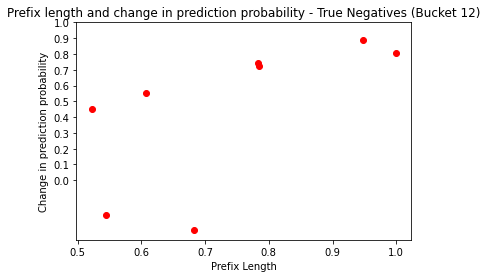

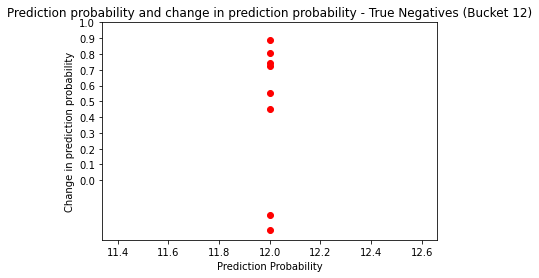

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for feature 14 of 44
Creating distribution for feature 15 of 44
Creating distribution for feature 16 of 44
Creating distribution for feature 17 of 44
Creating distribution for feature 18 of 44
Creating distribution for feature 19 of 44
Creating distribution for feature 20 of 44
Creating distribution for feature 21 of 44
Creating distribution

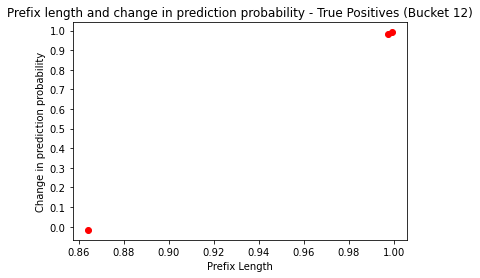

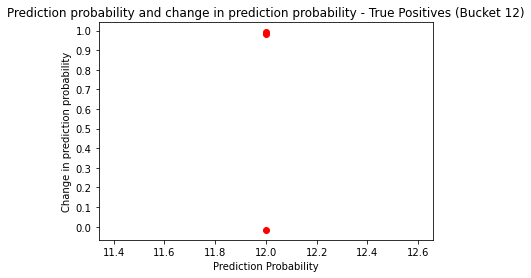

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for feature 14 of 44
Creating distribution for feature 15 of 44
Creating distribution for feature 16 of 44
Creating distribution for feature 17 of 44
Creating distribution for feature 18 of 44
Creating distribution for feature 19 of 44
Creating distribution for feature 20 of 44
Creating distribution for feature 21 of 44
Creating distribution

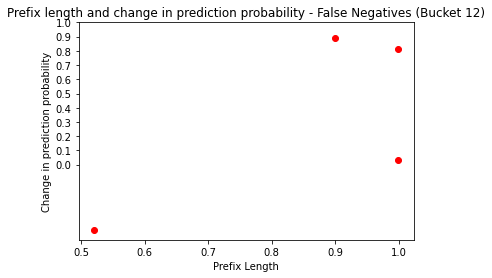

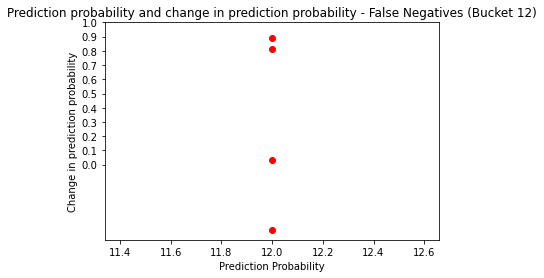

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for feature 14 of 44
Creating distribution for feature 15 of 44
Creating distribution for feature 16 of 44
Creating distribution for feature 17 of 44
Creating distribution for feature 18 of 44
Creating distribution for feature 19 of 44
Creating distribution for feature 20 of 44
Creating distribution for feature 21 of 44
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 44
Creating distribution for feature 2 of 44
Creating distribution for feature 3 of 44
Creating distribution for feature 4 of 44
Creating distribution for feature 5 of 44
Creating distribution for feature 6 of 44
Creating distribution for feature 7 of 44
Creating distribution for feature 8 of 44
Creating distribution for feature 9 of 44
Creating distribution for feature 10 of 44
Creating distribution for feature 11 of 44
Creating distribution for feature 12 of 44
Creating distribution for feature 13 of 44
Creating distribution for feature 14 of 44
Creating distribution for feature 15 of 44
Creating distribution for feature 16 of 44
Creating distribution for feature 17 of 44
Creating distribution for feature 18 of 44
Creating distribution for feature 19 of 44
Creating distribution for feature 20 of 44
Creating distribution for feature 21 of 44
Creating distribution for feature 22 of 44
Creating di

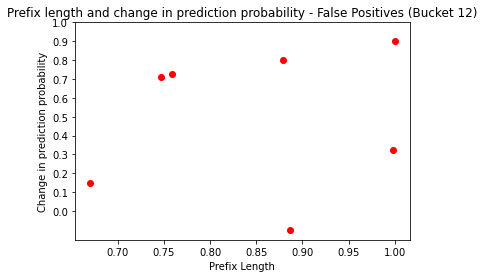

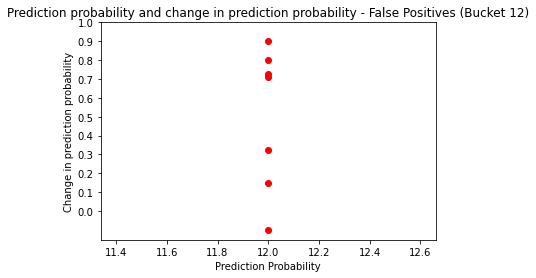

Bucket 13
Generating distributions for bucket
1 of 454 features
2 of 454 features
3 of 454 features
4 of 454 features
5 of 454 features
6 of 454 features
7 of 454 features
8 of 454 features
9 of 454 features
10 of 454 features
11 of 454 features
12 of 454 features
13 of 454 features
14 of 454 features
15 of 454 features
16 of 454 features
17 of 454 features
18 of 454 features
19 of 454 features
20 of 454 features
21 of 454 features
22 of 454 features
23 of 454 features
24 of 454 features
25 of 454 features
26 of 454 features
27 of 454 features
28 of 454 features
29 of 454 features
30 of 454 features
31 of 454 features
32 of 454 features
33 of 454 features
34 of 454 features
35 of 454 features
36 of 454 features
37 of 454 features
38 of 454 features
39 of 454 features
40 of 454 features
41 of 454 features
42 of 454 features
43 of 454 features
44 of 454 features
45 of 454 features
46 of 454 features
47 of 454 features
48 of 454 features
49 of 454 features
50 of 454 features
51 of 454 fea

414 of 454 features
415 of 454 features
416 of 454 features
417 of 454 features
418 of 454 features
419 of 454 features
420 of 454 features
421 of 454 features
422 of 454 features
423 of 454 features
424 of 454 features
425 of 454 features
426 of 454 features
427 of 454 features
428 of 454 features
429 of 454 features
430 of 454 features
431 of 454 features
432 of 454 features
433 of 454 features
434 of 454 features
435 of 454 features
436 of 454 features
437 of 454 features
438 of 454 features
439 of 454 features
440 of 454 features
441 of 454 features
442 of 454 features
443 of 454 features
444 of 454 features
445 of 454 features
446 of 454 features
447 of 454 features
448 of 454 features
449 of 454 features
450 of 454 features
451 of 454 features
452 of 454 features
453 of 454 features
454 of 454 features
Category 1 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution for feature 22 of 45
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution for feature 22 of 45
Creating di

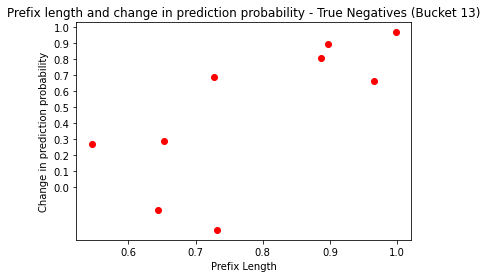

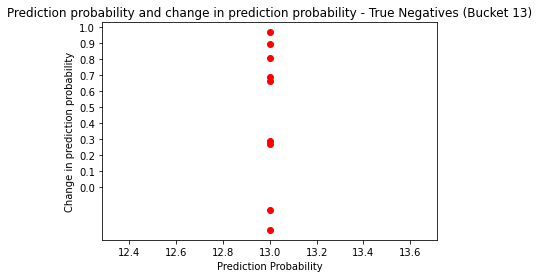

Category 2 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution

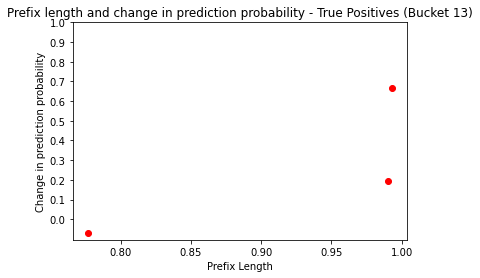

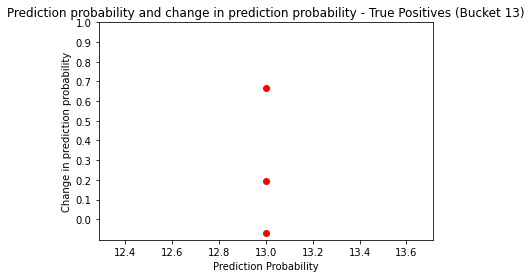

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution

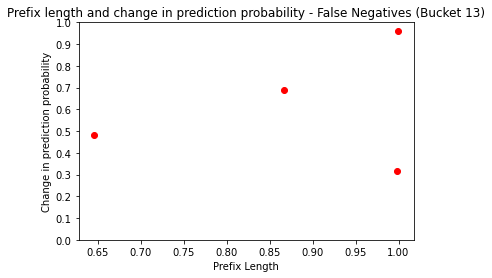

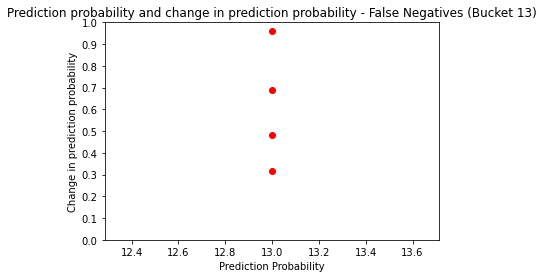

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 45
Creating distribution for feature 2 of 45
Creating distribution for feature 3 of 45
Creating distribution for feature 4 of 45
Creating distribution for feature 5 of 45
Creating distribution for feature 6 of 45
Creating distribution for feature 7 of 45
Creating distribution for feature 8 of 45
Creating distribution for feature 9 of 45
Creating distribution for feature 10 of 45
Creating distribution for feature 11 of 45
Creating distribution for feature 12 of 45
Creating distribution for feature 13 of 45
Creating distribution for feature 14 of 45
Creating distribution for feature 15 of 45
Creating distribution for feature 16 of 45
Creating distribution for feature 17 of 45
Creating distribution for feature 18 of 45
Creating distribution for feature 19 of 45
Creating distribution for feature 20 of 45
Creating distribution for feature 21 of 45
Creating distribution for feature 22 of 45
Creating di

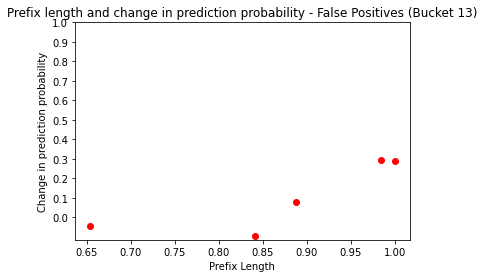

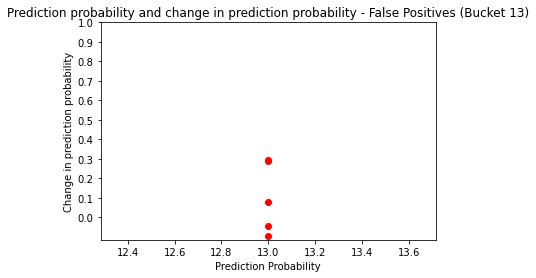

Bucket 14
Generating distributions for bucket
1 of 464 features
2 of 464 features
3 of 464 features
4 of 464 features
5 of 464 features
6 of 464 features
7 of 464 features
8 of 464 features
9 of 464 features
10 of 464 features
11 of 464 features
12 of 464 features
13 of 464 features
14 of 464 features
15 of 464 features
16 of 464 features
17 of 464 features
18 of 464 features
19 of 464 features
20 of 464 features
21 of 464 features
22 of 464 features
23 of 464 features
24 of 464 features
25 of 464 features
26 of 464 features
27 of 464 features
28 of 464 features
29 of 464 features
30 of 464 features
31 of 464 features
32 of 464 features
33 of 464 features
34 of 464 features
35 of 464 features
36 of 464 features
37 of 464 features
38 of 464 features
39 of 464 features
40 of 464 features
41 of 464 features
42 of 464 features
43 of 464 features
44 of 464 features
45 of 464 features
46 of 464 features
47 of 464 features
48 of 464 features
49 of 464 features
50 of 464 features
51 of 464 fea

421 of 464 features
422 of 464 features
423 of 464 features
424 of 464 features
425 of 464 features
426 of 464 features
427 of 464 features
428 of 464 features
429 of 464 features
430 of 464 features
431 of 464 features
432 of 464 features
433 of 464 features
434 of 464 features
435 of 464 features
436 of 464 features
437 of 464 features
438 of 464 features
439 of 464 features
440 of 464 features
441 of 464 features
442 of 464 features
443 of 464 features
444 of 464 features
445 of 464 features
446 of 464 features
447 of 464 features
448 of 464 features
449 of 464 features
450 of 464 features
451 of 464 features
452 of 464 features
453 of 464 features
454 of 464 features
455 of 464 features
456 of 464 features
457 of 464 features
458 of 464 features
459 of 464 features
460 of 464 features
461 of 464 features
462 of 464 features
463 of 464 features
464 of 464 features
Category 1 of 4. Instance 1 of 9
Creating explanations
Identifying relevant features
Creating distribution for feature 1

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution for feature 22 of 46
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution for feature 22 of 46
Creating di

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution

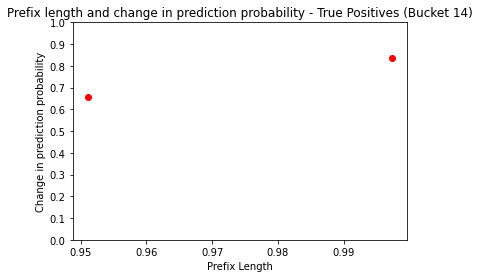

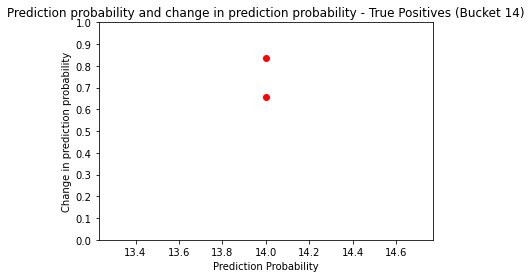

Category 3 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution

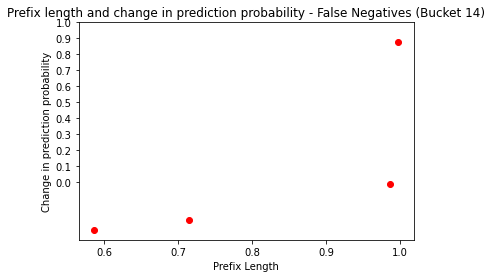

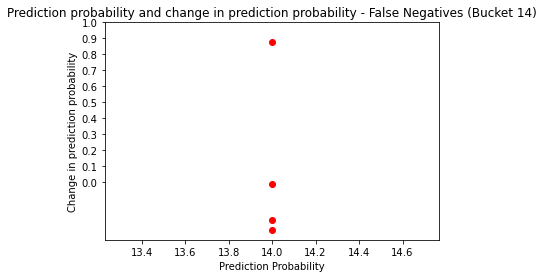

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 46
Creating distribution for feature 2 of 46
Creating distribution for feature 3 of 46
Creating distribution for feature 4 of 46
Creating distribution for feature 5 of 46
Creating distribution for feature 6 of 46
Creating distribution for feature 7 of 46
Creating distribution for feature 8 of 46
Creating distribution for feature 9 of 46
Creating distribution for feature 10 of 46
Creating distribution for feature 11 of 46
Creating distribution for feature 12 of 46
Creating distribution for feature 13 of 46
Creating distribution for feature 14 of 46
Creating distribution for feature 15 of 46
Creating distribution for feature 16 of 46
Creating distribution for feature 17 of 46
Creating distribution for feature 18 of 46
Creating distribution for feature 19 of 46
Creating distribution for feature 20 of 46
Creating distribution for feature 21 of 46
Creating distribution for feature 22 of 46
Creating di

Bucket 15
Generating distributions for bucket
1 of 478 features
2 of 478 features
3 of 478 features
4 of 478 features
5 of 478 features
6 of 478 features
7 of 478 features
8 of 478 features
9 of 478 features
10 of 478 features
11 of 478 features
12 of 478 features
13 of 478 features
14 of 478 features
15 of 478 features
16 of 478 features
17 of 478 features
18 of 478 features
19 of 478 features
20 of 478 features
21 of 478 features
22 of 478 features
23 of 478 features
24 of 478 features
25 of 478 features
26 of 478 features
27 of 478 features
28 of 478 features
29 of 478 features
30 of 478 features
31 of 478 features
32 of 478 features
33 of 478 features
34 of 478 features
35 of 478 features
36 of 478 features
37 of 478 features
38 of 478 features
39 of 478 features
40 of 478 features
41 of 478 features
42 of 478 features
43 of 478 features
44 of 478 features
45 of 478 features
46 of 478 features
47 of 478 features
48 of 478 features
49 of 478 features
50 of 478 features
51 of 478 fea

423 of 478 features
424 of 478 features
425 of 478 features
426 of 478 features
427 of 478 features
428 of 478 features
429 of 478 features
430 of 478 features
431 of 478 features
432 of 478 features
433 of 478 features
434 of 478 features
435 of 478 features
436 of 478 features
437 of 478 features
438 of 478 features
439 of 478 features
440 of 478 features
441 of 478 features
442 of 478 features
443 of 478 features
444 of 478 features
445 of 478 features
446 of 478 features
447 of 478 features
448 of 478 features
449 of 478 features
450 of 478 features
451 of 478 features
452 of 478 features
453 of 478 features
454 of 478 features
455 of 478 features
456 of 478 features
457 of 478 features
458 of 478 features
459 of 478 features
460 of 478 features
461 of 478 features
462 of 478 features
463 of 478 features
464 of 478 features
465 of 478 features
466 of 478 features
467 of 478 features
468 of 478 features
469 of 478 features
470 of 478 features
471 of 478 features
472 of 478 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

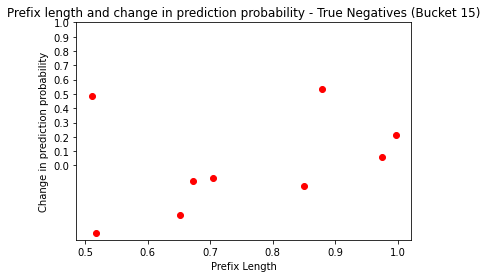

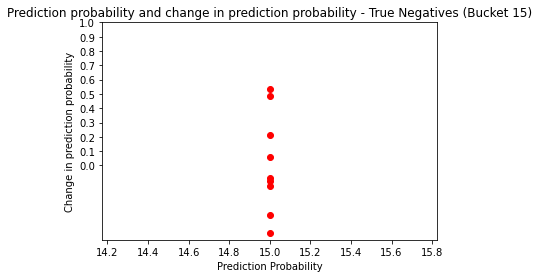

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

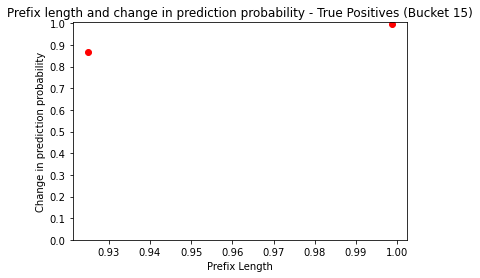

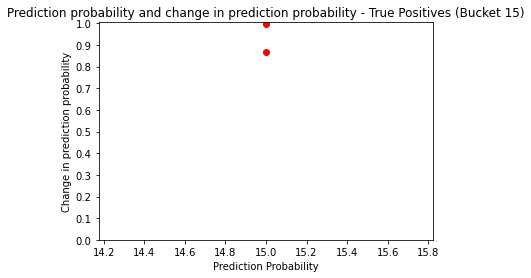

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

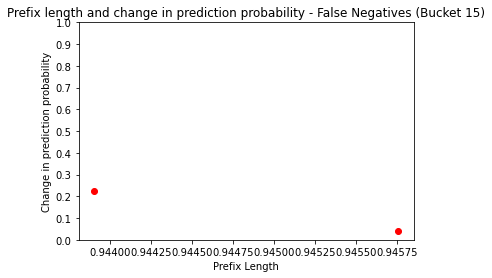

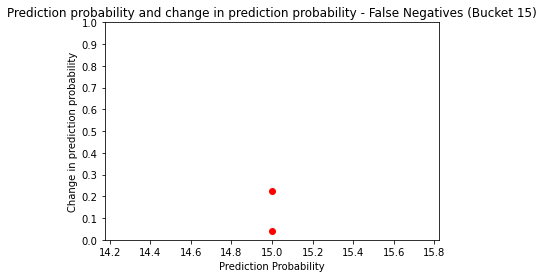

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

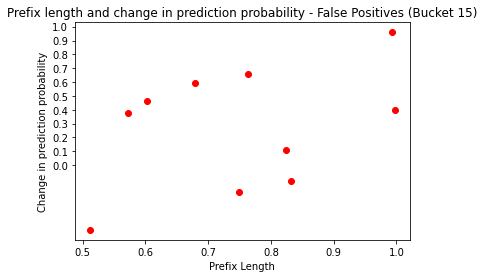

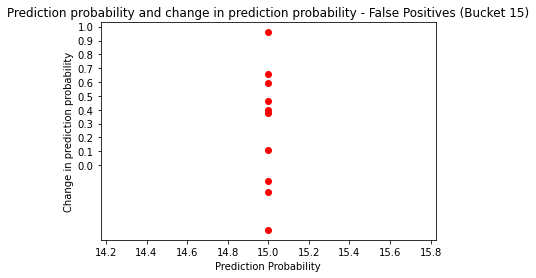

Bucket 16
Generating distributions for bucket
1 of 481 features
2 of 481 features
3 of 481 features
4 of 481 features
5 of 481 features
6 of 481 features
7 of 481 features
8 of 481 features
9 of 481 features
10 of 481 features
11 of 481 features
12 of 481 features
13 of 481 features
14 of 481 features
15 of 481 features
16 of 481 features
17 of 481 features
18 of 481 features
19 of 481 features
20 of 481 features
21 of 481 features
22 of 481 features
23 of 481 features
24 of 481 features
25 of 481 features
26 of 481 features
27 of 481 features
28 of 481 features
29 of 481 features
30 of 481 features
31 of 481 features
32 of 481 features
33 of 481 features
34 of 481 features
35 of 481 features
36 of 481 features
37 of 481 features
38 of 481 features
39 of 481 features
40 of 481 features
41 of 481 features
42 of 481 features
43 of 481 features
44 of 481 features
45 of 481 features
46 of 481 features
47 of 481 features
48 of 481 features
49 of 481 features
50 of 481 features
51 of 481 fea

435 of 481 features
436 of 481 features
437 of 481 features
438 of 481 features
439 of 481 features
440 of 481 features
441 of 481 features
442 of 481 features
443 of 481 features
444 of 481 features
445 of 481 features
446 of 481 features
447 of 481 features
448 of 481 features
449 of 481 features
450 of 481 features
451 of 481 features
452 of 481 features
453 of 481 features
454 of 481 features
455 of 481 features
456 of 481 features
457 of 481 features
458 of 481 features
459 of 481 features
460 of 481 features
461 of 481 features
462 of 481 features
463 of 481 features
464 of 481 features
465 of 481 features
466 of 481 features
467 of 481 features
468 of 481 features
469 of 481 features
470 of 481 features
471 of 481 features
472 of 481 features
473 of 481 features
474 of 481 features
475 of 481 features
476 of 481 features
477 of 481 features
478 of 481 features
479 of 481 features
480 of 481 features
481 of 481 features
Category 1 of 4. Instance 1 of 6
Creating explanations
Ident

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

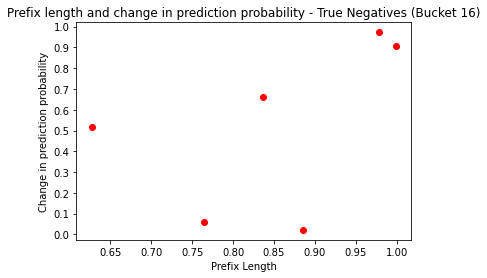

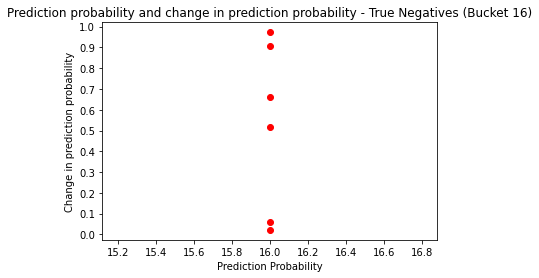

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

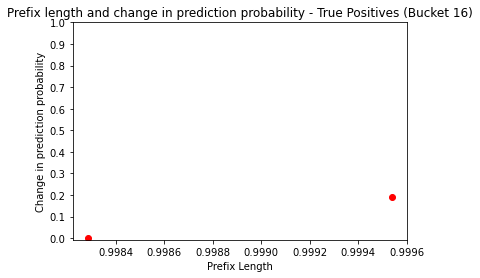

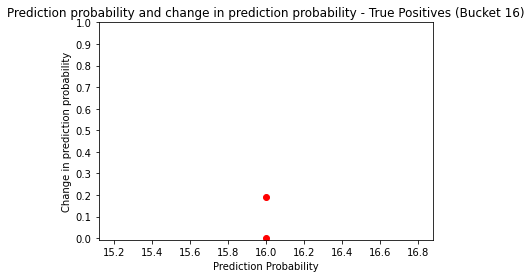

Category 3 of 4. Instance 1 of 3
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

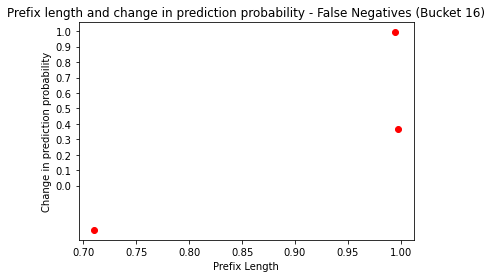

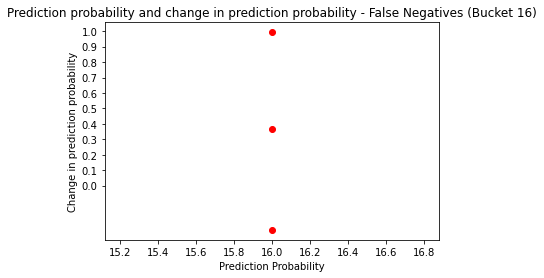

Category 4 of 4. Instance 1 of 5
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

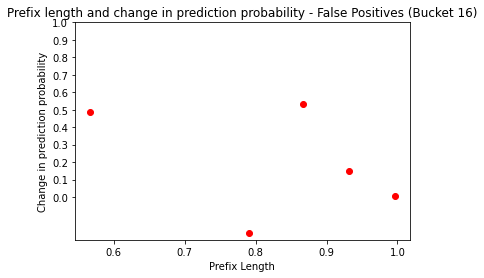

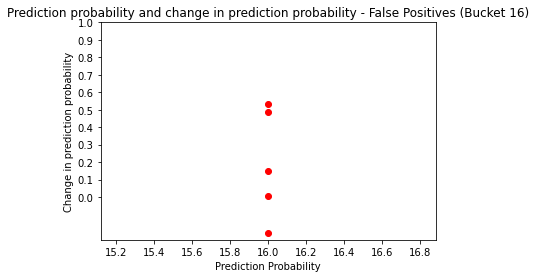

Bucket 17
Generating distributions for bucket
1 of 474 features
2 of 474 features
3 of 474 features
4 of 474 features
5 of 474 features
6 of 474 features
7 of 474 features
8 of 474 features
9 of 474 features
10 of 474 features
11 of 474 features
12 of 474 features
13 of 474 features
14 of 474 features
15 of 474 features
16 of 474 features
17 of 474 features
18 of 474 features
19 of 474 features
20 of 474 features
21 of 474 features
22 of 474 features
23 of 474 features
24 of 474 features
25 of 474 features
26 of 474 features
27 of 474 features
28 of 474 features
29 of 474 features
30 of 474 features
31 of 474 features
32 of 474 features
33 of 474 features
34 of 474 features
35 of 474 features
36 of 474 features
37 of 474 features
38 of 474 features
39 of 474 features
40 of 474 features
41 of 474 features
42 of 474 features
43 of 474 features
44 of 474 features
45 of 474 features
46 of 474 features
47 of 474 features
48 of 474 features
49 of 474 features
50 of 474 features
51 of 474 fea

450 of 474 features
451 of 474 features
452 of 474 features
453 of 474 features
454 of 474 features
455 of 474 features
456 of 474 features
457 of 474 features
458 of 474 features
459 of 474 features
460 of 474 features
461 of 474 features
462 of 474 features
463 of 474 features
464 of 474 features
465 of 474 features
466 of 474 features
467 of 474 features
468 of 474 features
469 of 474 features
470 of 474 features
471 of 474 features
472 of 474 features
473 of 474 features
474 of 474 features
Category 1 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

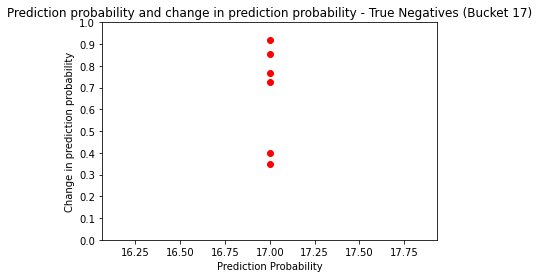

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

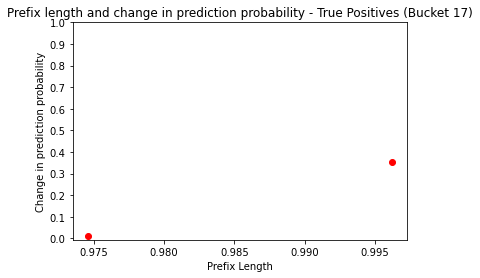

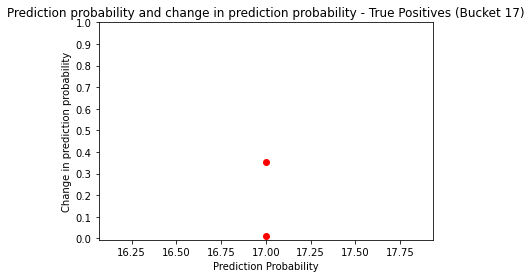

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

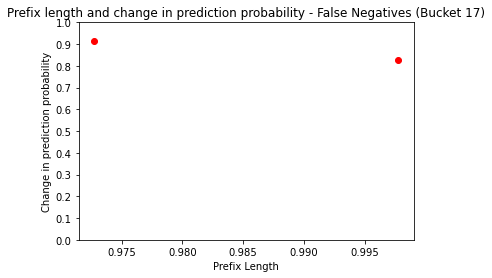

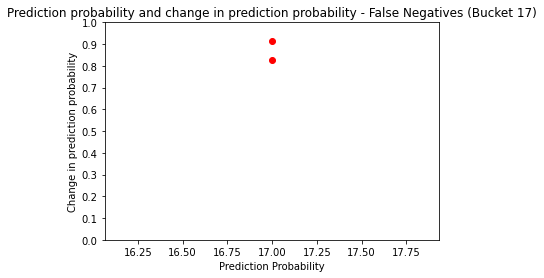

Category 4 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

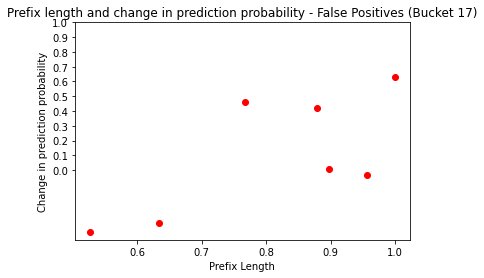

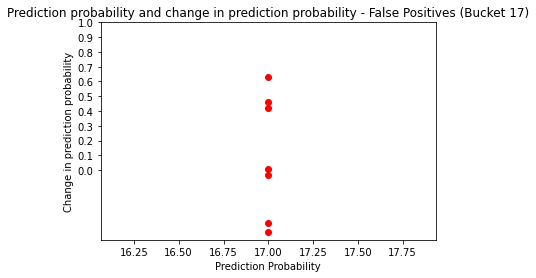

Bucket 18
Generating distributions for bucket
1 of 476 features
2 of 476 features
3 of 476 features
4 of 476 features
5 of 476 features
6 of 476 features
7 of 476 features
8 of 476 features
9 of 476 features
10 of 476 features
11 of 476 features
12 of 476 features
13 of 476 features
14 of 476 features
15 of 476 features
16 of 476 features
17 of 476 features
18 of 476 features
19 of 476 features
20 of 476 features
21 of 476 features
22 of 476 features
23 of 476 features
24 of 476 features
25 of 476 features
26 of 476 features
27 of 476 features
28 of 476 features
29 of 476 features
30 of 476 features
31 of 476 features
32 of 476 features
33 of 476 features
34 of 476 features
35 of 476 features
36 of 476 features
37 of 476 features
38 of 476 features
39 of 476 features
40 of 476 features
41 of 476 features
42 of 476 features
43 of 476 features
44 of 476 features
45 of 476 features
46 of 476 features
47 of 476 features
48 of 476 features
49 of 476 features
50 of 476 features
51 of 476 fea

469 of 476 features
470 of 476 features
471 of 476 features
472 of 476 features
473 of 476 features
474 of 476 features
475 of 476 features
476 of 476 features
Category 1 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

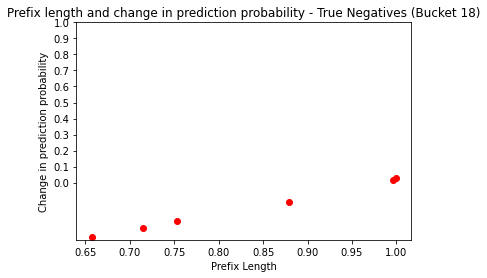

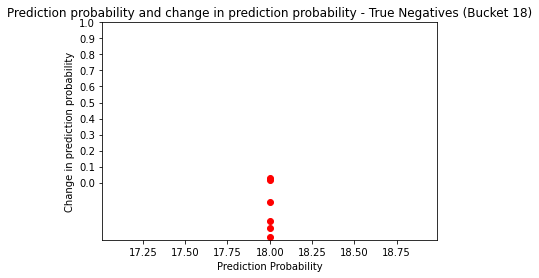

Category 2 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

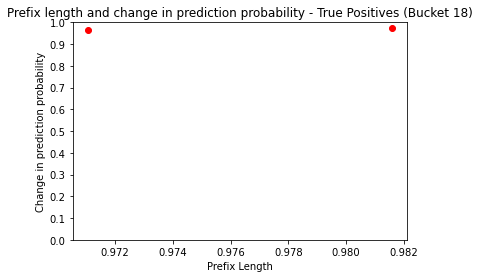

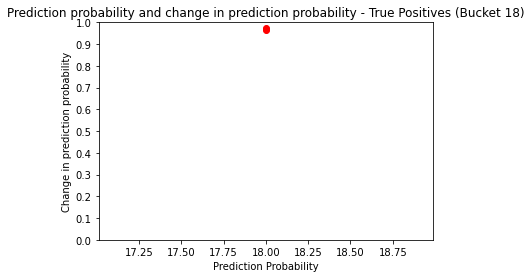

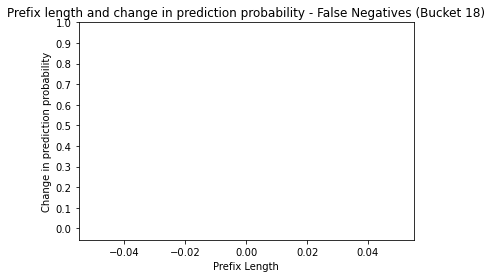

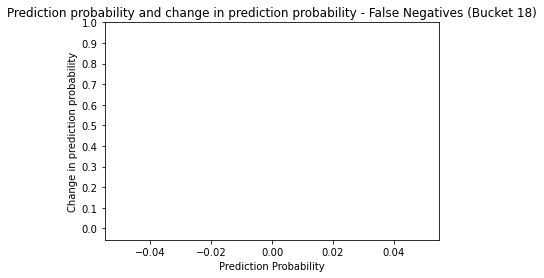

Category 4 of 4. Instance 1 of 6
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

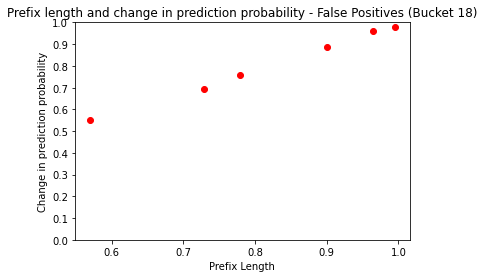

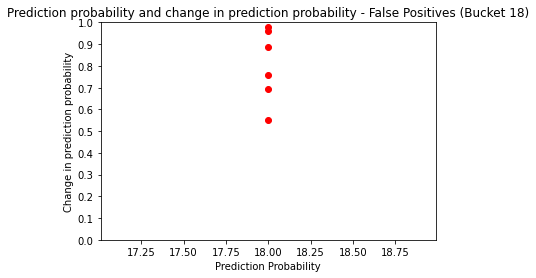

Bucket 19
Generating distributions for bucket
1 of 471 features
2 of 471 features
3 of 471 features
4 of 471 features
5 of 471 features
6 of 471 features
7 of 471 features
8 of 471 features
9 of 471 features
10 of 471 features
11 of 471 features
12 of 471 features
13 of 471 features
14 of 471 features
15 of 471 features
16 of 471 features
17 of 471 features
18 of 471 features
19 of 471 features
20 of 471 features
21 of 471 features
22 of 471 features
23 of 471 features
24 of 471 features
25 of 471 features
26 of 471 features
27 of 471 features
28 of 471 features
29 of 471 features
30 of 471 features
31 of 471 features
32 of 471 features
33 of 471 features
34 of 471 features
35 of 471 features
36 of 471 features
37 of 471 features
38 of 471 features
39 of 471 features
40 of 471 features
41 of 471 features
42 of 471 features
43 of 471 features
44 of 471 features
45 of 471 features
46 of 471 features
47 of 471 features
48 of 471 features
49 of 471 features
50 of 471 features
51 of 471 fea

428 of 471 features
429 of 471 features
430 of 471 features
431 of 471 features
432 of 471 features
433 of 471 features
434 of 471 features
435 of 471 features
436 of 471 features
437 of 471 features
438 of 471 features
439 of 471 features
440 of 471 features
441 of 471 features
442 of 471 features
443 of 471 features
444 of 471 features
445 of 471 features
446 of 471 features
447 of 471 features
448 of 471 features
449 of 471 features
450 of 471 features
451 of 471 features
452 of 471 features
453 of 471 features
454 of 471 features
455 of 471 features
456 of 471 features
457 of 471 features
458 of 471 features
459 of 471 features
460 of 471 features
461 of 471 features
462 of 471 features
463 of 471 features
464 of 471 features
465 of 471 features
466 of 471 features
467 of 471 features
468 of 471 features
469 of 471 features
470 of 471 features
471 of 471 features
Category 1 of 4. Instance 1 of 7
Creating explanations
Identifying relevant features
Creating distribution for feature 1

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution for feature 22 of 47
Creating di

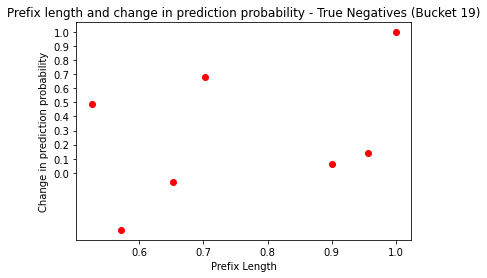

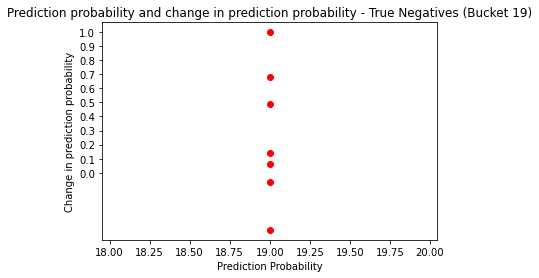

Category 2 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

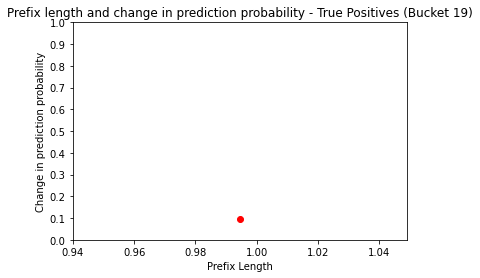

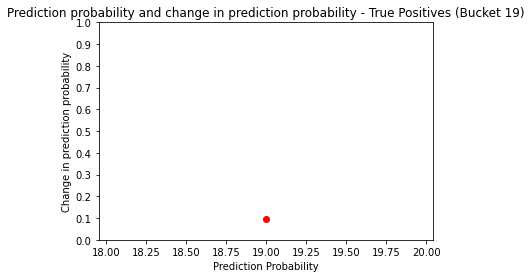

Category 3 of 4. Instance 1 of 1
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

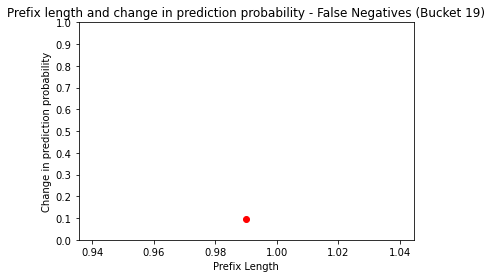

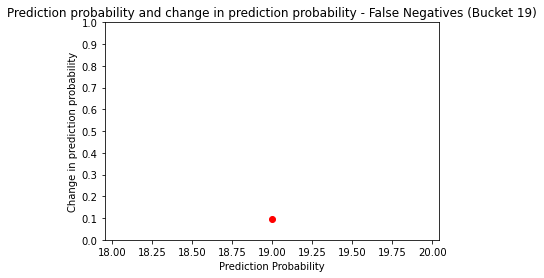

Category 4 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 47
Creating distribution for feature 2 of 47
Creating distribution for feature 3 of 47
Creating distribution for feature 4 of 47
Creating distribution for feature 5 of 47
Creating distribution for feature 6 of 47
Creating distribution for feature 7 of 47
Creating distribution for feature 8 of 47
Creating distribution for feature 9 of 47
Creating distribution for feature 10 of 47
Creating distribution for feature 11 of 47
Creating distribution for feature 12 of 47
Creating distribution for feature 13 of 47
Creating distribution for feature 14 of 47
Creating distribution for feature 15 of 47
Creating distribution for feature 16 of 47
Creating distribution for feature 17 of 47
Creating distribution for feature 18 of 47
Creating distribution for feature 19 of 47
Creating distribution for feature 20 of 47
Creating distribution for feature 21 of 47
Creating distribution

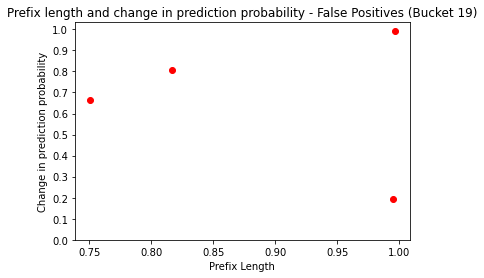

Bucket 20
Generating distributions for bucket
1 of 506 features
2 of 506 features
3 of 506 features
4 of 506 features
5 of 506 features
6 of 506 features
7 of 506 features
8 of 506 features
9 of 506 features
10 of 506 features
11 of 506 features
12 of 506 features
13 of 506 features
14 of 506 features
15 of 506 features
16 of 506 features
17 of 506 features
18 of 506 features
19 of 506 features
20 of 506 features
21 of 506 features
22 of 506 features
23 of 506 features
24 of 506 features
25 of 506 features
26 of 506 features
27 of 506 features
28 of 506 features
29 of 506 features
30 of 506 features
31 of 506 features
32 of 506 features
33 of 506 features
34 of 506 features
35 of 506 features
36 of 506 features
37 of 506 features
38 of 506 features
39 of 506 features
40 of 506 features
41 of 506 features
42 of 506 features
43 of 506 features
44 of 506 features
45 of 506 features
46 of 506 features
47 of 506 features
48 of 506 features
49 of 506 features
50 of 506 features
51 of 506 fea

482 of 506 features
483 of 506 features
484 of 506 features
485 of 506 features
486 of 506 features
487 of 506 features
488 of 506 features
489 of 506 features
490 of 506 features
491 of 506 features
492 of 506 features
493 of 506 features
494 of 506 features
495 of 506 features
496 of 506 features
497 of 506 features
498 of 506 features
499 of 506 features
500 of 506 features
501 of 506 features
502 of 506 features
503 of 506 features
504 of 506 features
505 of 506 features
506 of 506 features
Category 1 of 4. Instance 1 of 8
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 51
Creating distribution for feature 2 of 51
Creating distribution for feature 3 of 51
Creating distribution for feature 4 of 51
Creating distribution for feature 5 of 51
Creating distribution for feature 6 of 51
Creating distribution for feature 7 of 51
Creating distribution for feature 8 of 51
Creating distribution for feature 9 of 51
Creating distribution for feature 10 

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 51
Creating distribution for feature 2 of 51
Creating distribution for feature 3 of 51
Creating distribution for feature 4 of 51
Creating distribution for feature 5 of 51
Creating distribution for feature 6 of 51
Creating distribution for feature 7 of 51
Creating distribution for feature 8 of 51
Creating distribution for feature 9 of 51
Creating distribution for feature 10 of 51
Creating distribution for feature 11 of 51
Creating distribution for feature 12 of 51
Creating distribution for feature 13 of 51
Creating distribution for feature 14 of 51
Creating distribution for feature 15 of 51
Creating distribution for feature 16 of 51
Creating distribution for feature 17 of 51
Creating distribution for feature 18 of 51
Creating distribution for feature 19 of 51
Creating distribution for feature 20 of 51
Creating distribution for feature 21 of 51
Creating distribution for feature 22 of 51
Creating di

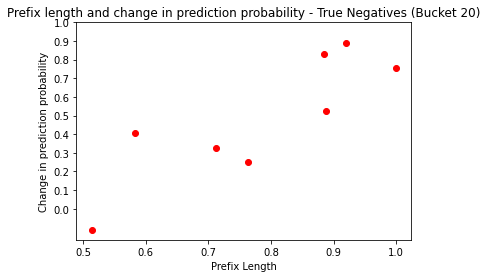

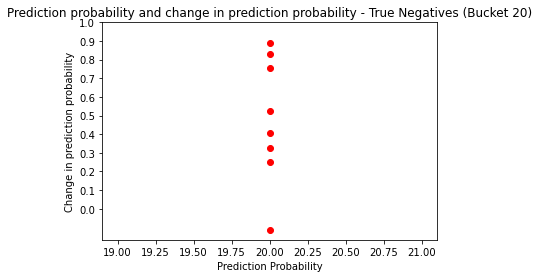

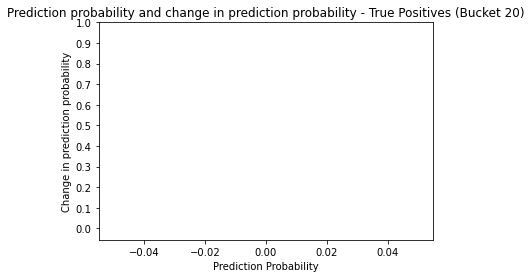

Category 3 of 4. Instance 1 of 2
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 51
Creating distribution for feature 2 of 51
Creating distribution for feature 3 of 51
Creating distribution for feature 4 of 51
Creating distribution for feature 5 of 51
Creating distribution for feature 6 of 51
Creating distribution for feature 7 of 51
Creating distribution for feature 8 of 51
Creating distribution for feature 9 of 51
Creating distribution for feature 10 of 51
Creating distribution for feature 11 of 51
Creating distribution for feature 12 of 51
Creating distribution for feature 13 of 51
Creating distribution for feature 14 of 51
Creating distribution for feature 15 of 51
Creating distribution for feature 16 of 51
Creating distribution for feature 17 of 51
Creating distribution for feature 18 of 51
Creating distribution for feature 19 of 51
Creating distribution for feature 20 of 51
Creating distribution for feature 21 of 51
Creating distribution

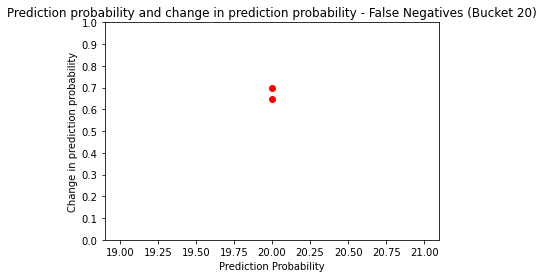

Category 4 of 4. Instance 1 of 4
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 51
Creating distribution for feature 2 of 51
Creating distribution for feature 3 of 51
Creating distribution for feature 4 of 51
Creating distribution for feature 5 of 51
Creating distribution for feature 6 of 51
Creating distribution for feature 7 of 51
Creating distribution for feature 8 of 51
Creating distribution for feature 9 of 51
Creating distribution for feature 10 of 51
Creating distribution for feature 11 of 51
Creating distribution for feature 12 of 51
Creating distribution for feature 13 of 51
Creating distribution for feature 14 of 51
Creating distribution for feature 15 of 51
Creating distribution for feature 16 of 51
Creating distribution for feature 17 of 51
Creating distribution for feature 18 of 51
Creating distribution for feature 19 of 51
Creating distribution for feature 20 of 51
Creating distribution for feature 21 of 51
Creating distribution

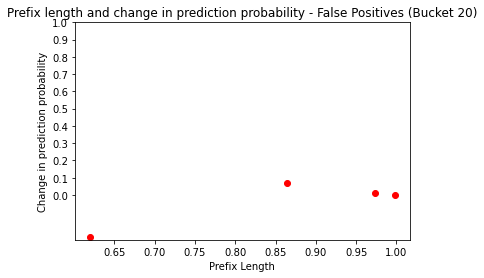

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val
                            if interval == 0:
                                interval = 1

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

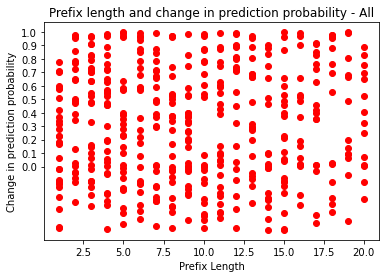

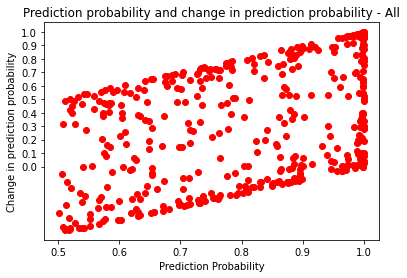

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

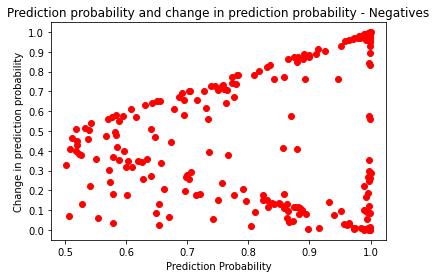

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribu

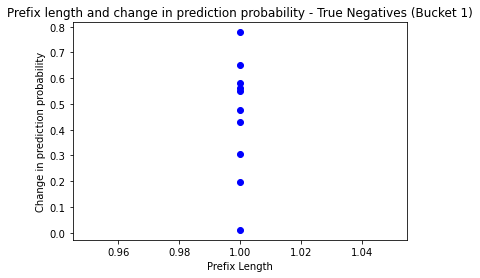

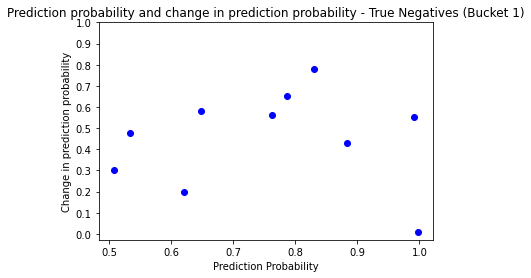

Category 2 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for fe

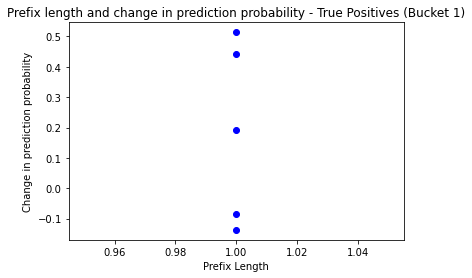

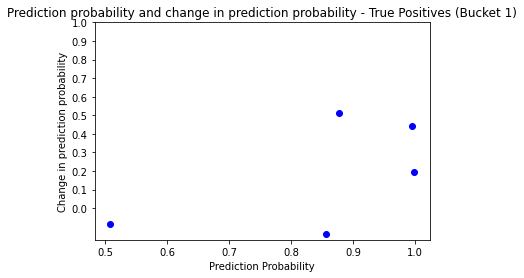

Category 3 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for fe

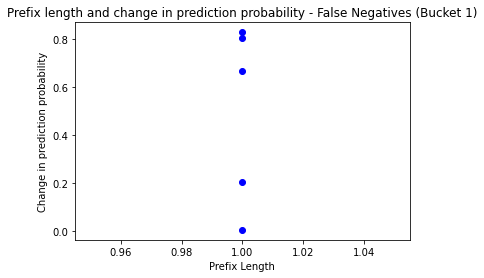

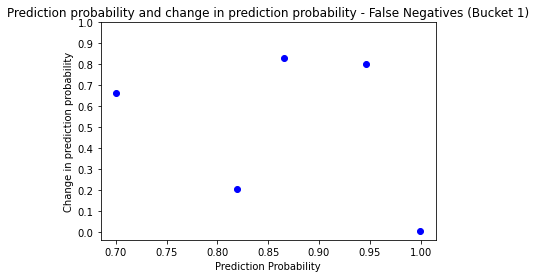

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for fe

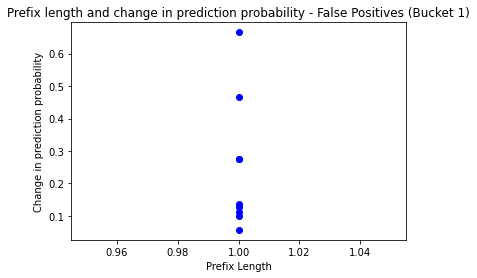

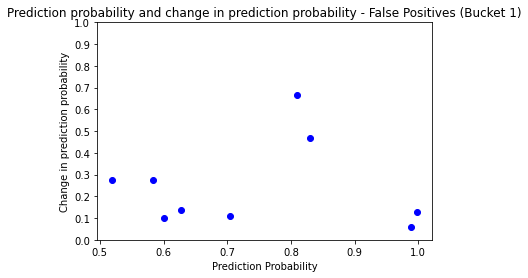

Bucket 2
Category 1 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribut

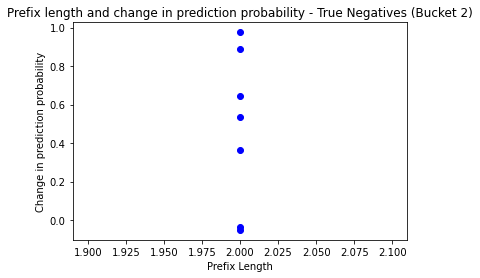

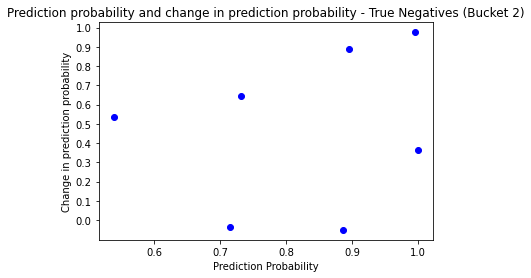

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for f

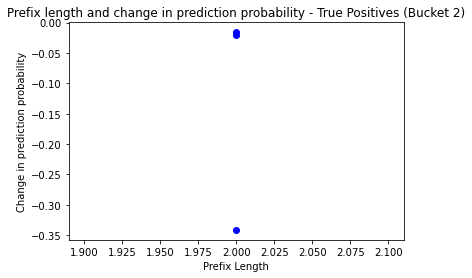

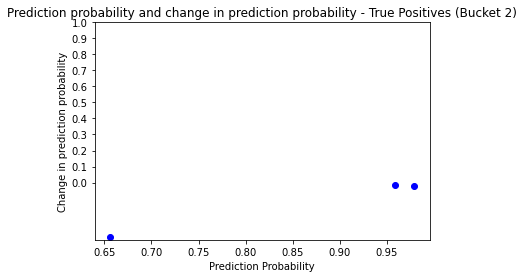

Category 3 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for f

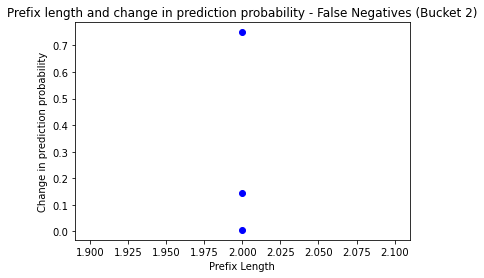

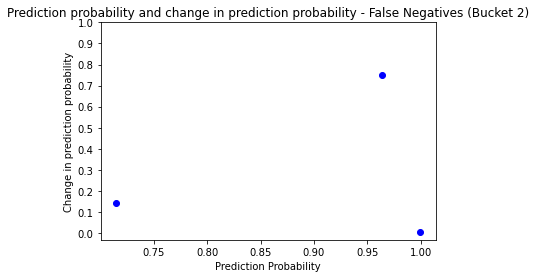

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for f

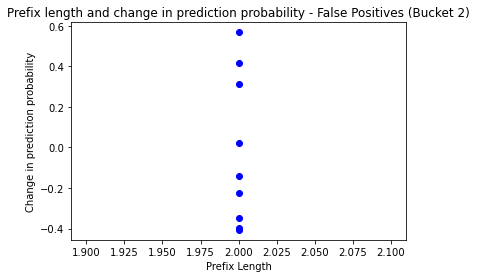

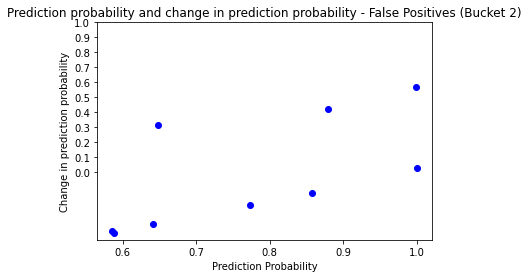

Bucket 3
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating dist

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


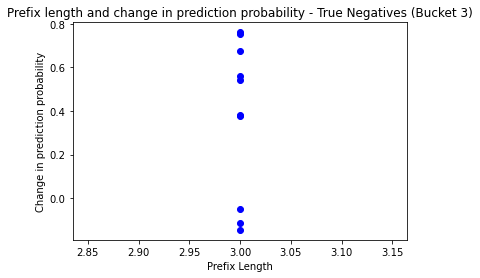

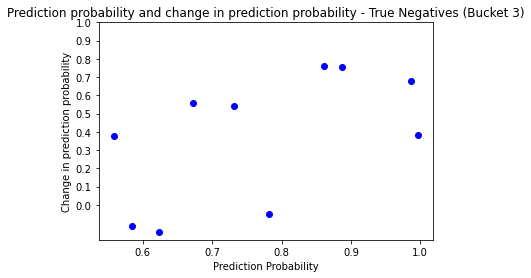

Category 2 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 7
Creating distribution for feature 0
Creating distribution fo

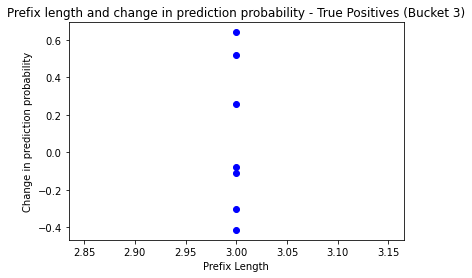

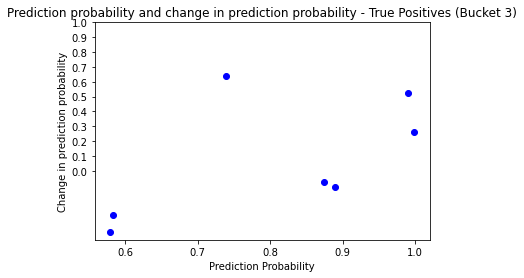

Category 3 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 3
Creating distribution for feature 0
Creating distribution fo

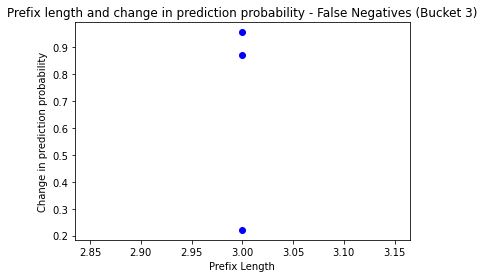

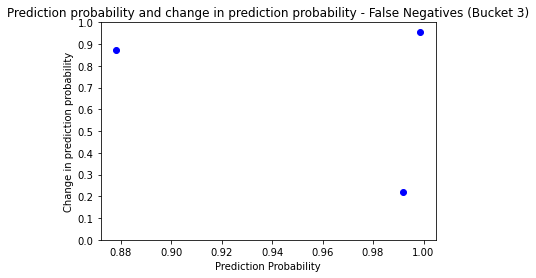

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution 

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


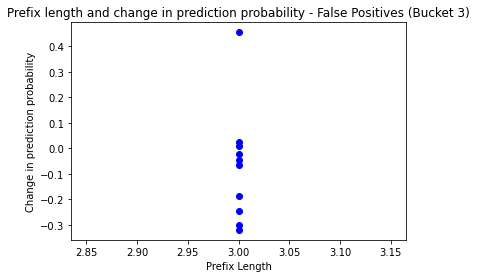

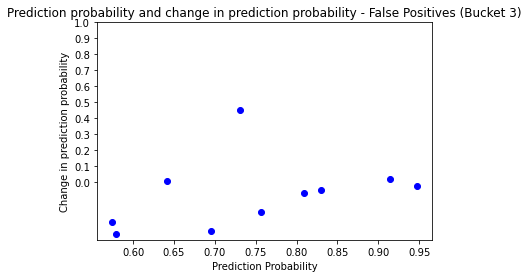

Bucket 4
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


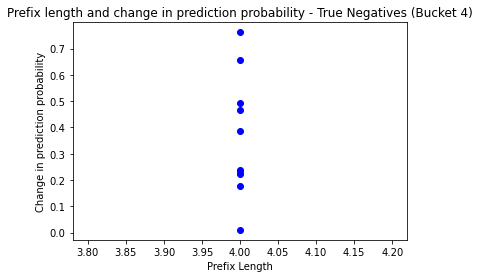

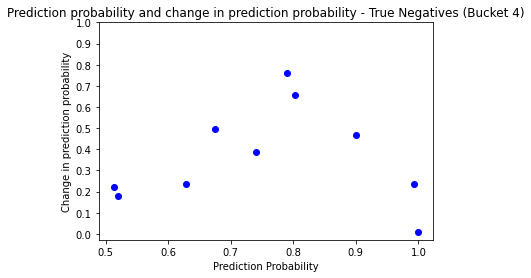

Category 2 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. In

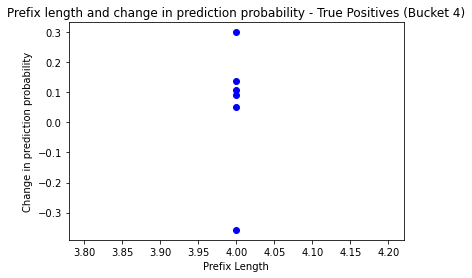

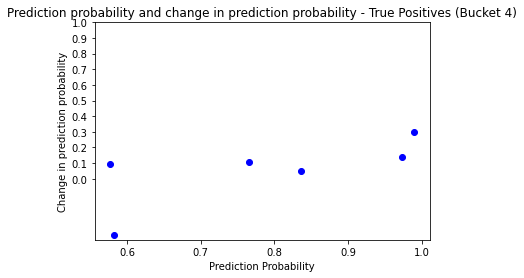

Category 3 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. In

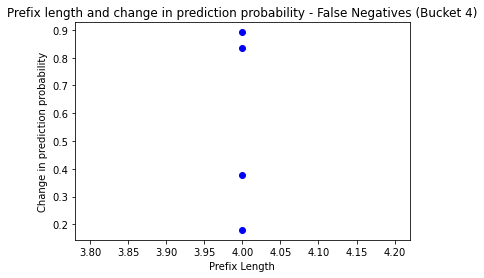

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. I

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


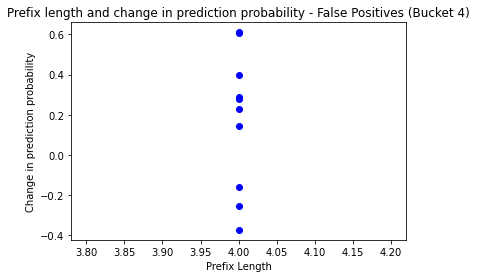

Bucket 5
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubi

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Ru

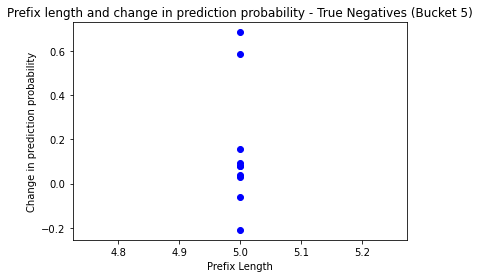

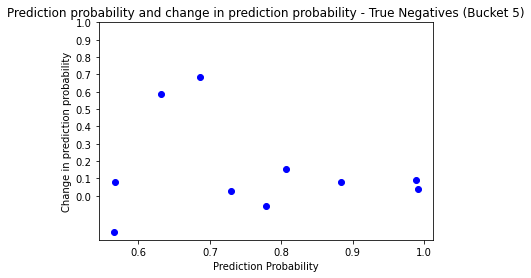

Category 2 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5

Category 3 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5

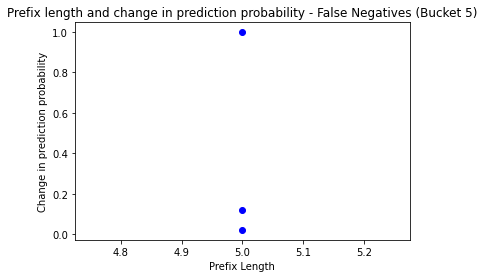

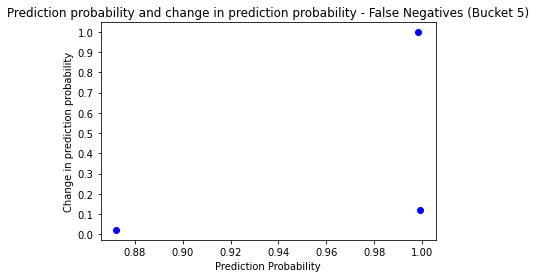

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Ru

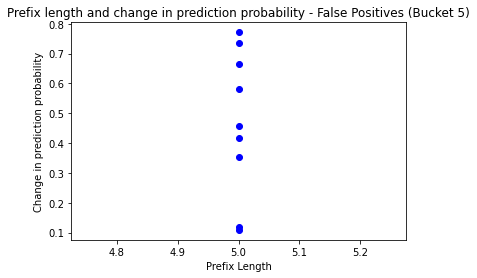

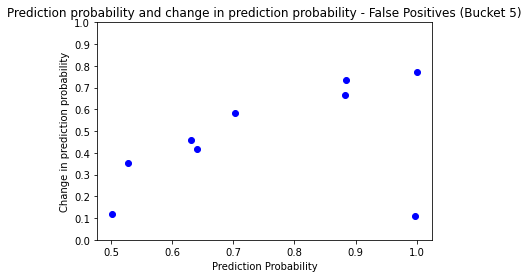

Bucket 6
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertub

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertubing - Run 1
Pertubing - Run 2
Pertubing - 

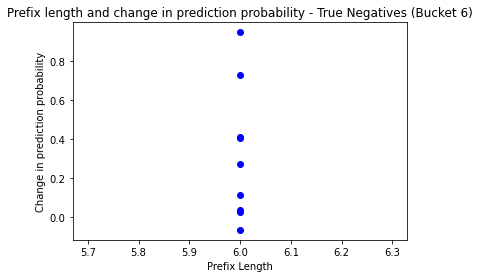

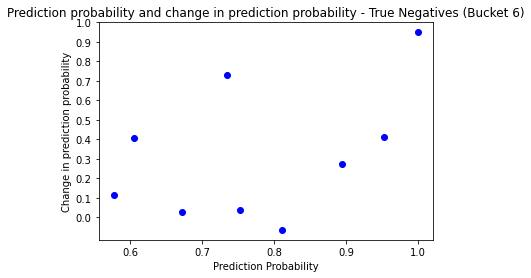

Category 2 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertubing - Run

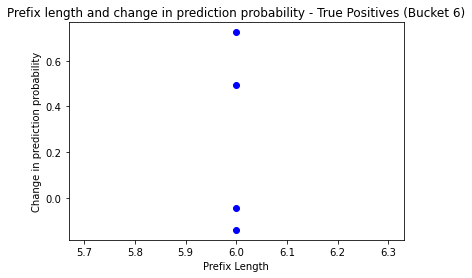

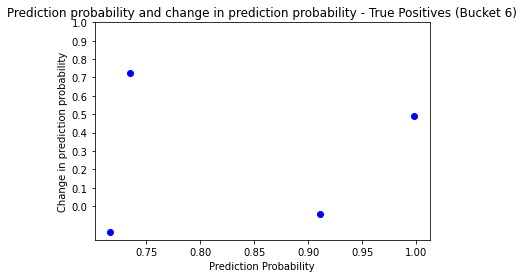

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertubing - Run

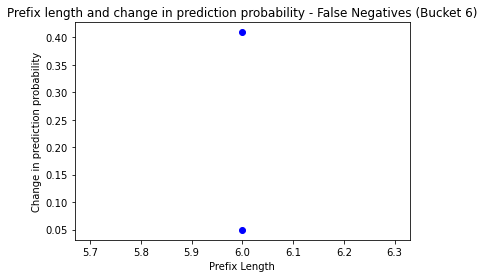

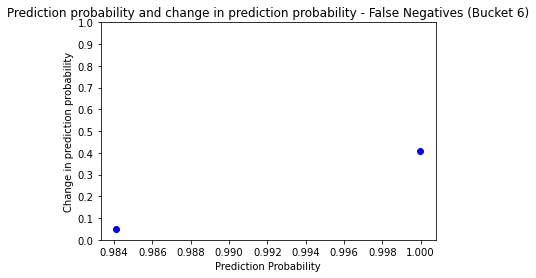

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertubing - Ru

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Pertubing - Run 1
Pertubing - Run 2
Pertubing - 

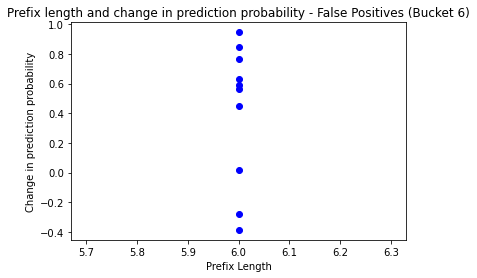

Bucket 7
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creati

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Category 3 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

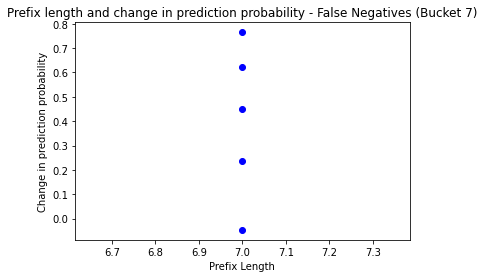

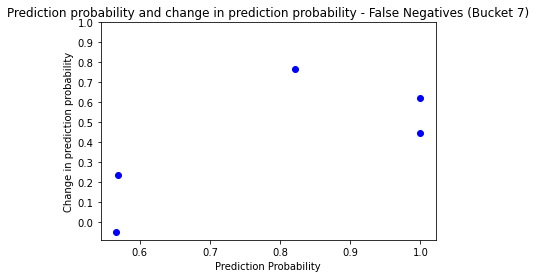

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Bucket 8
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

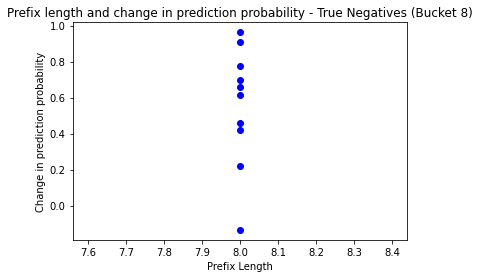

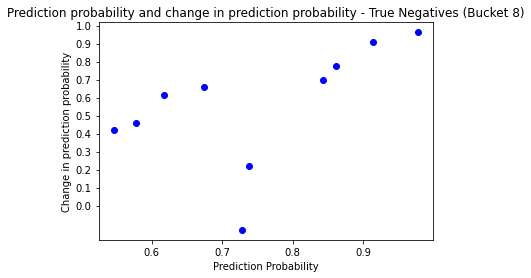

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

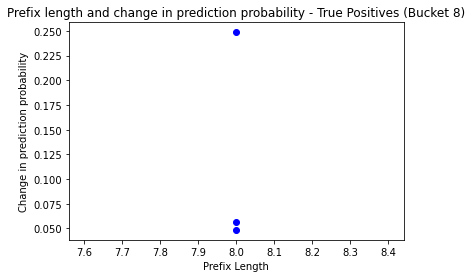

Category 3 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

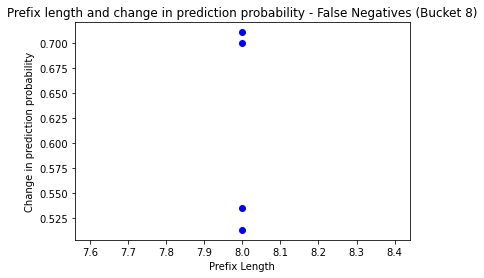

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

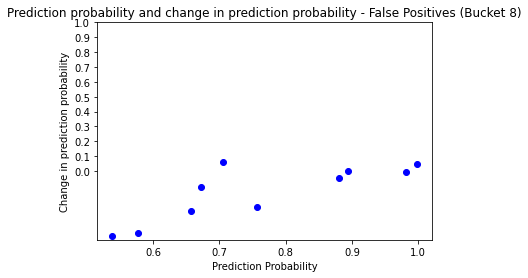

Bucket 9
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

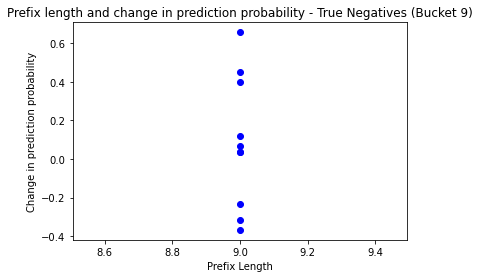

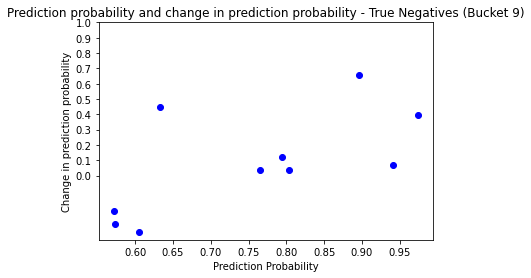

Category 2 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

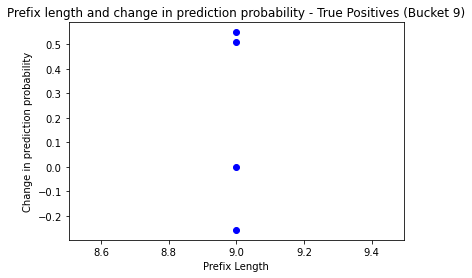

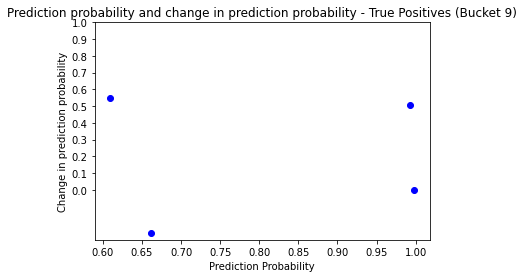

Category 3 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

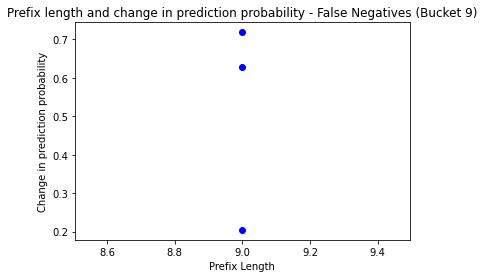

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

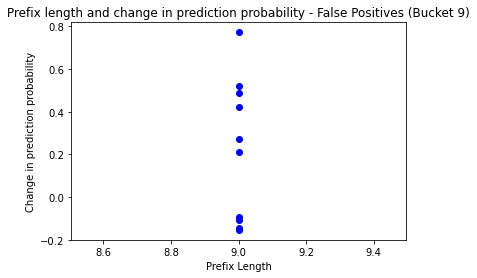

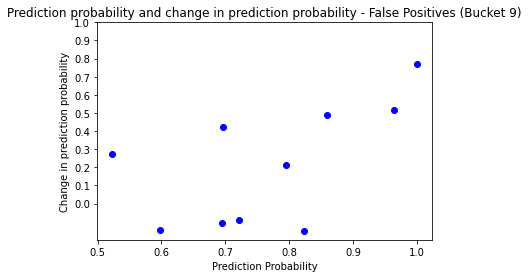

Bucket 10
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Crea

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

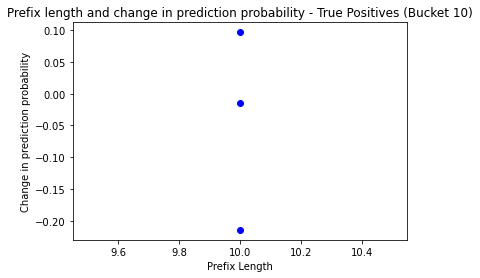

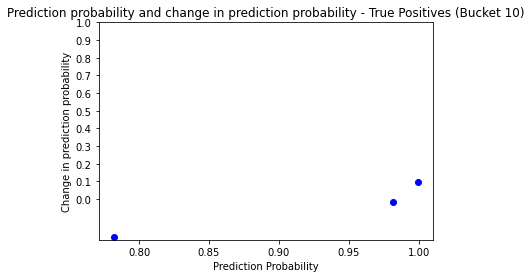

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

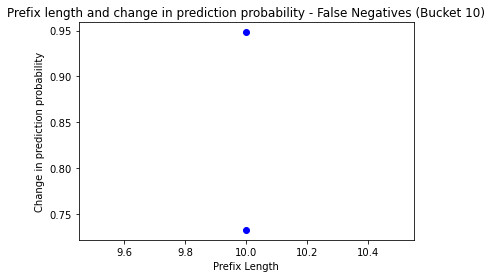

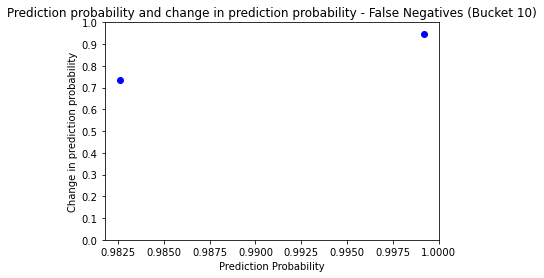

Category 4 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

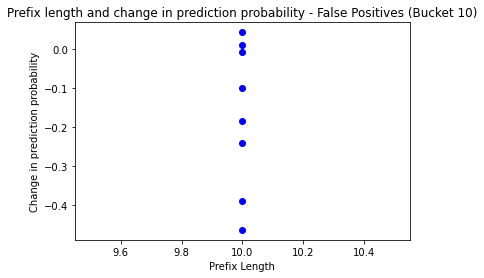

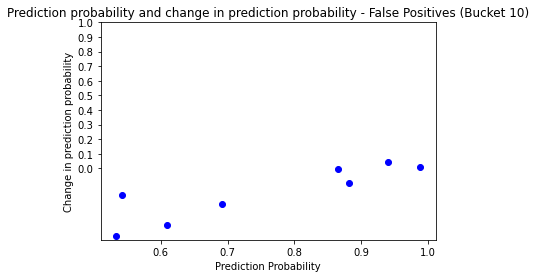

Bucket 11
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Crea

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Category 2 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

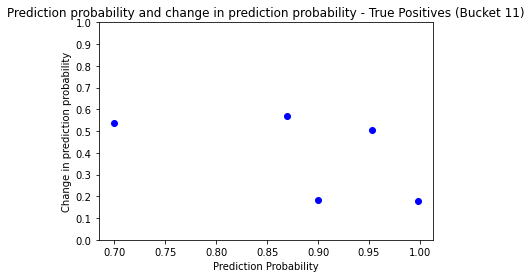

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

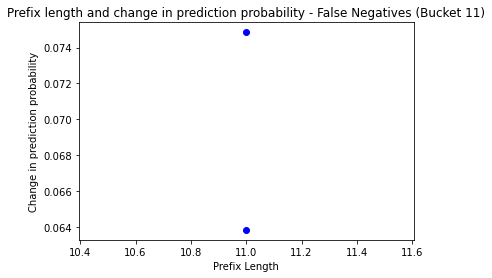

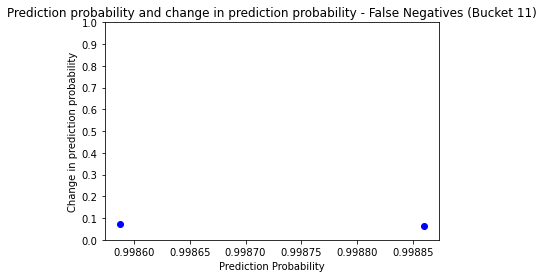

Category 4 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

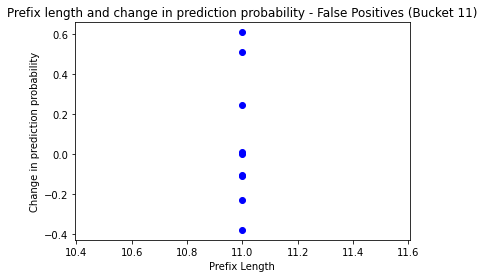

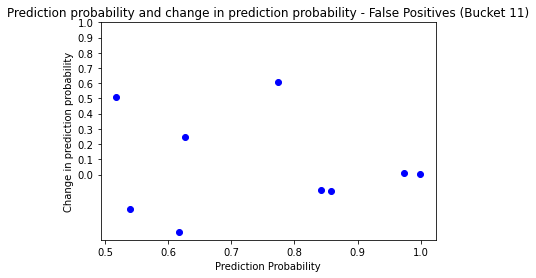

Bucket 12
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

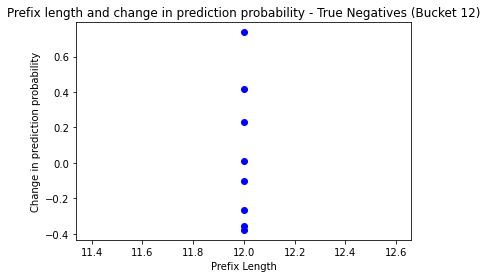

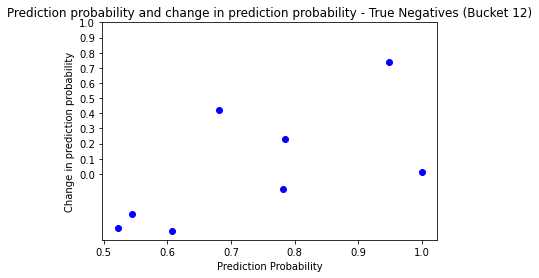

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

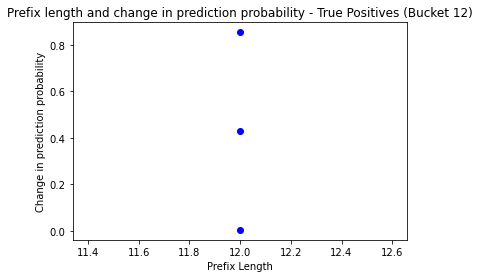

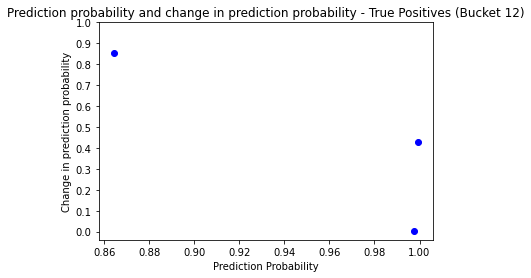

Category 3 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

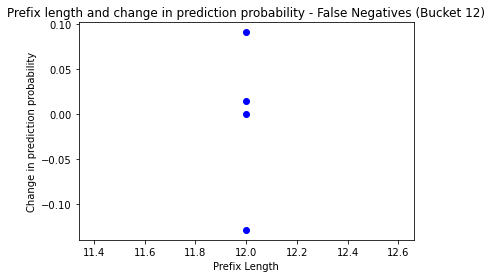

Category 4 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

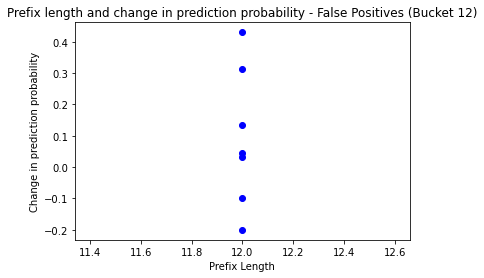

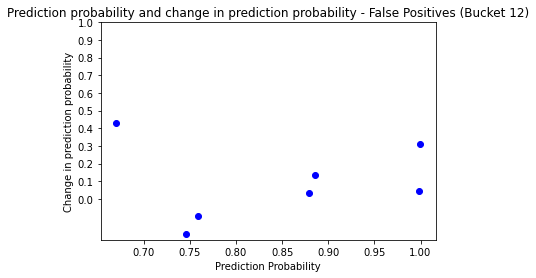

Bucket 13
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

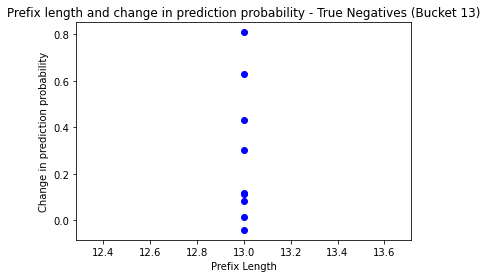

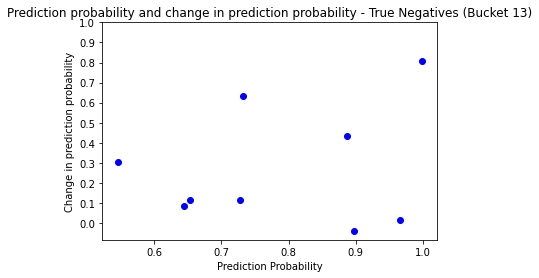

Category 2 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

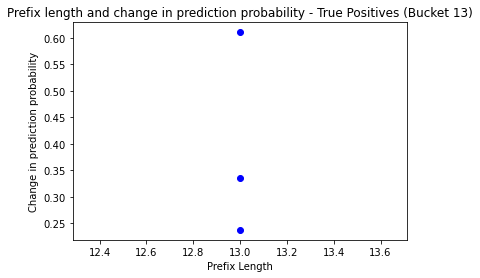

Category 3 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

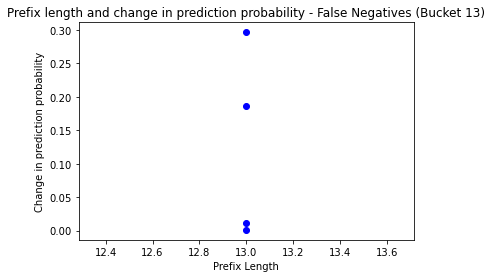

Category 4 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

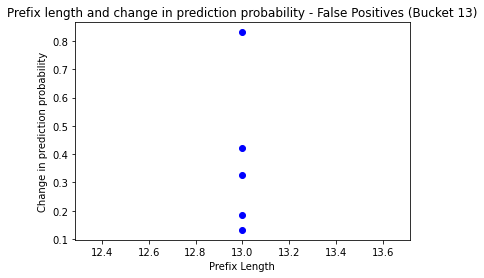

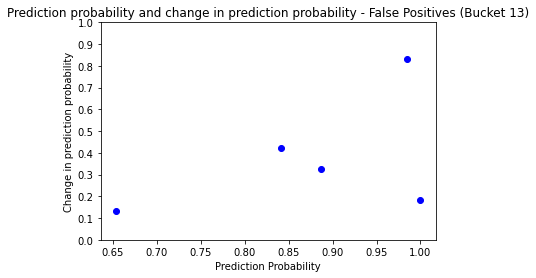

Bucket 14
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

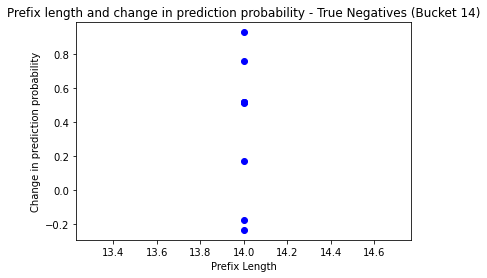

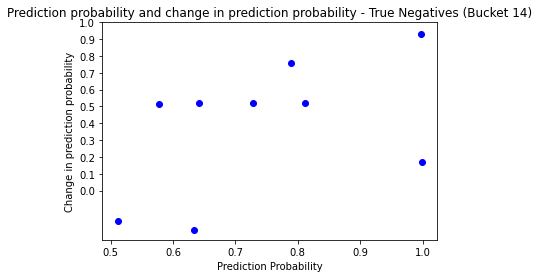

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

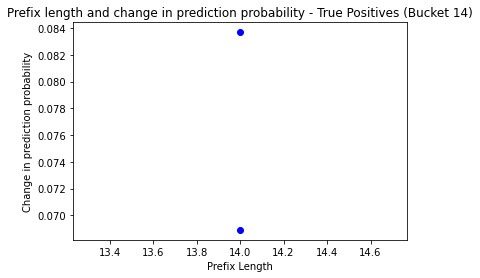

Category 3 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

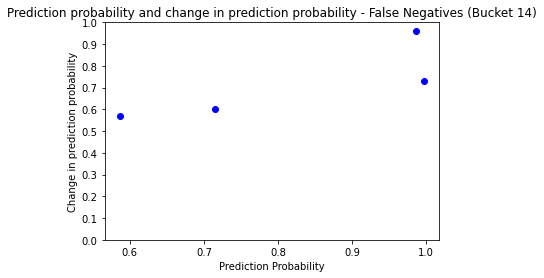

Category 4 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

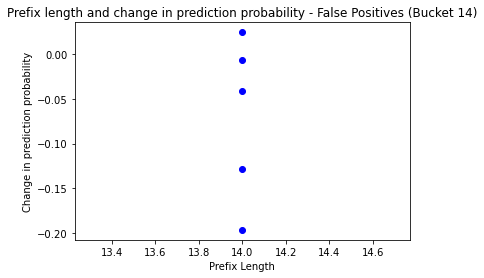

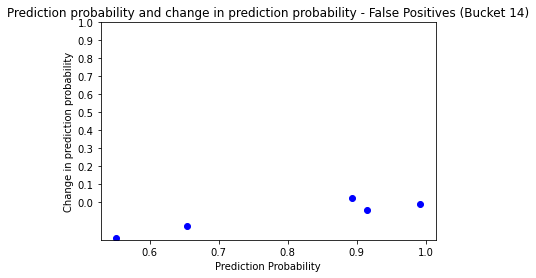

Bucket 15
Category 1 of 4. Instance 1 of 9
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

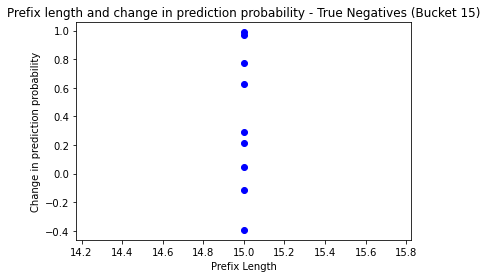

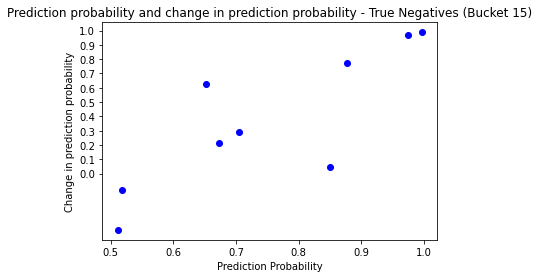

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

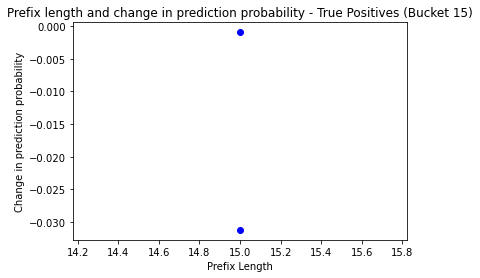

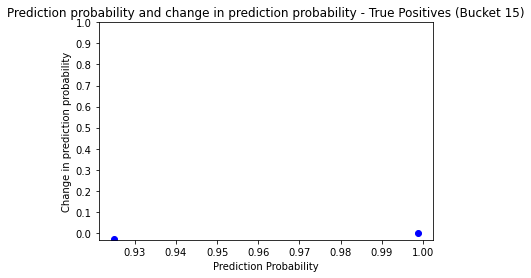

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

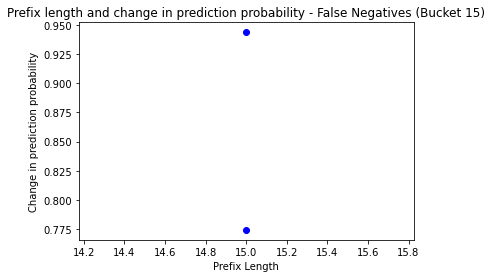

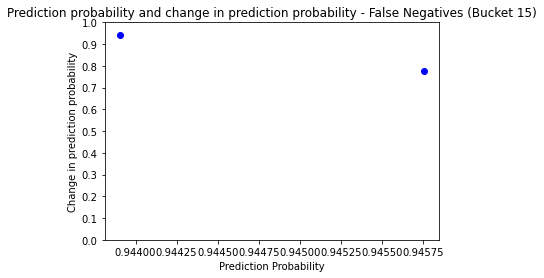

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

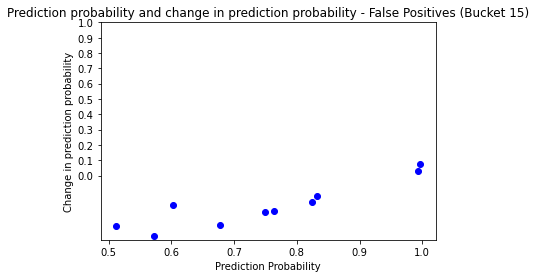

Bucket 16
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

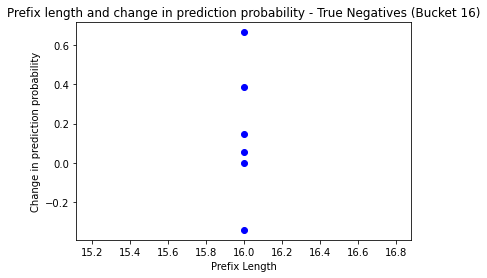

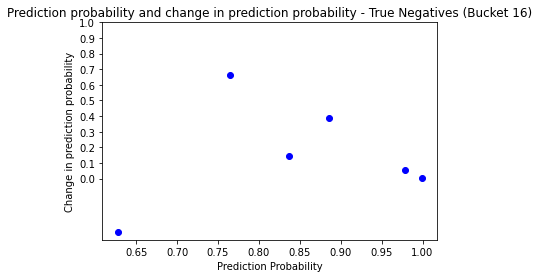

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

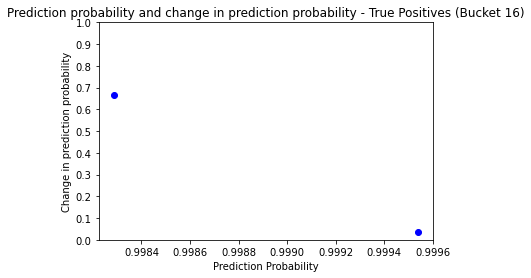

Category 3 of 4. Instance 1 of 3
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

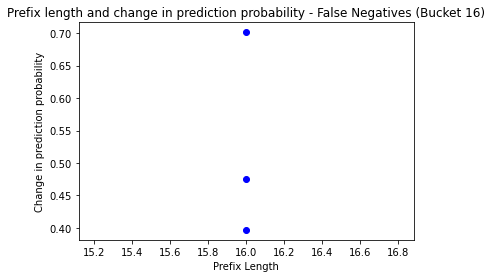

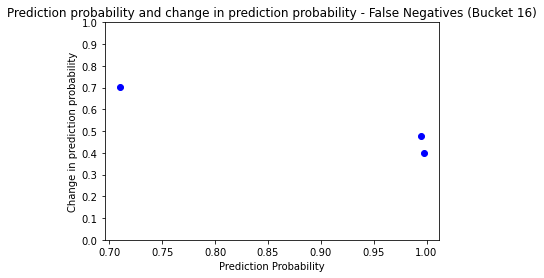

Category 4 of 4. Instance 1 of 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

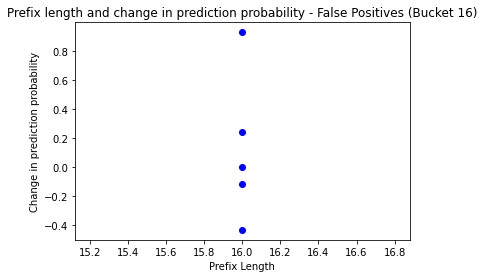

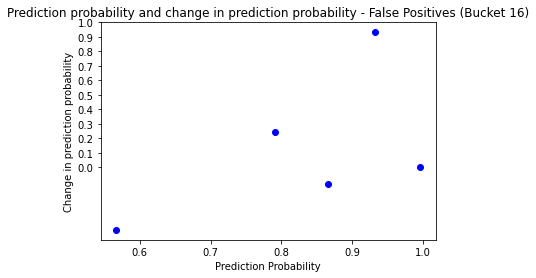

Bucket 17
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

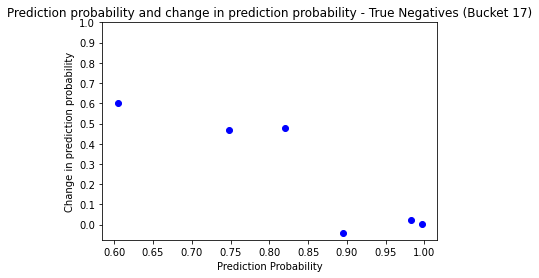

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

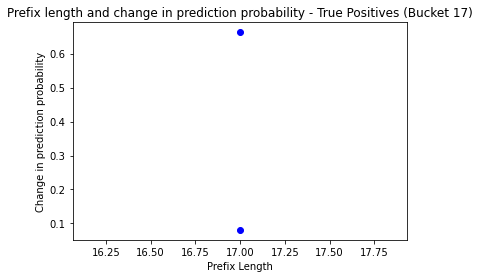

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

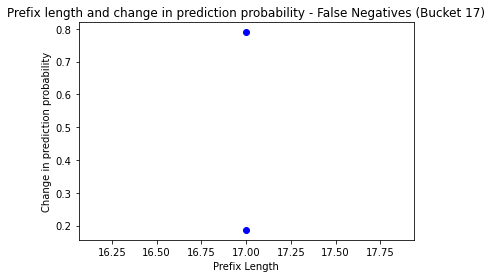

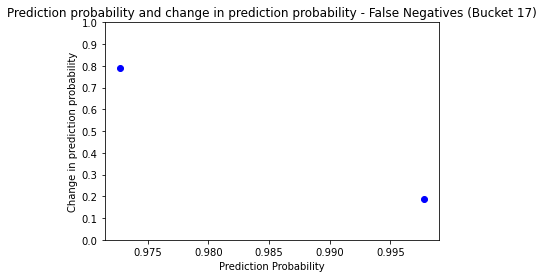

Category 4 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

Bucket 18
Category 1 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

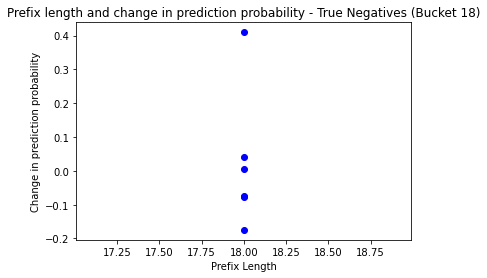

Category 2 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

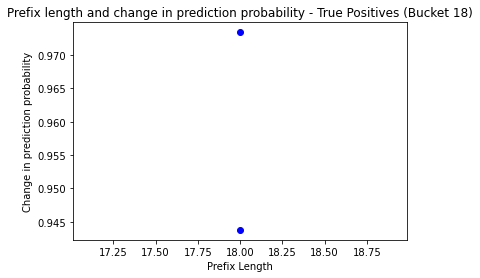

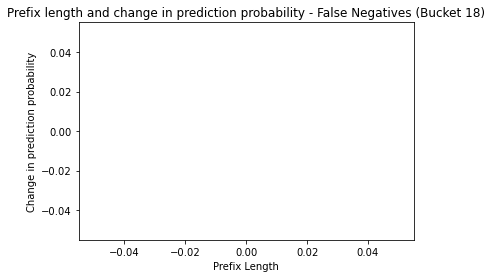

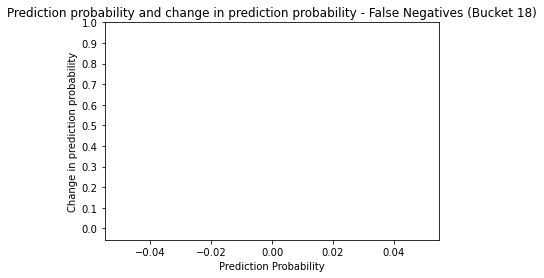

Category 4 of 4. Instance 1 of 6
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

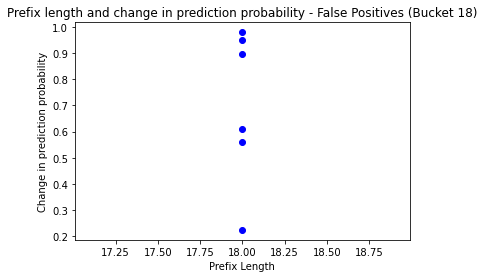

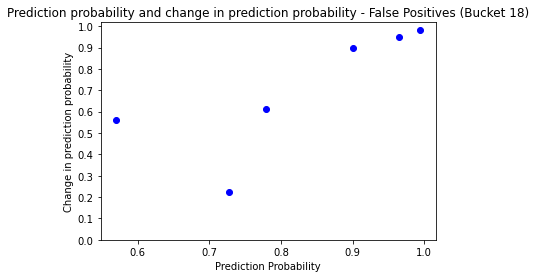

Bucket 19
Category 1 of 4. Instance 1 of 7
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

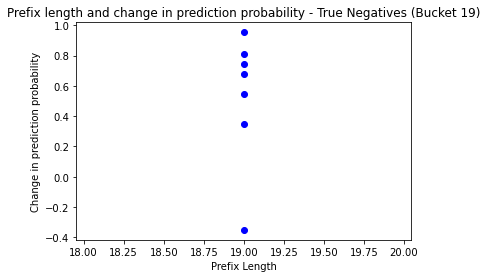

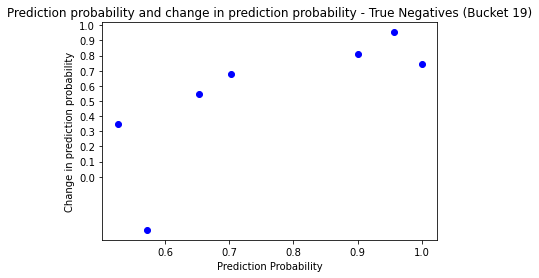

Category 2 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

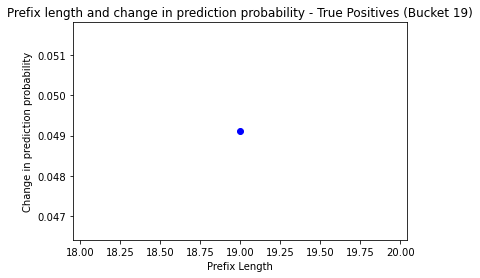

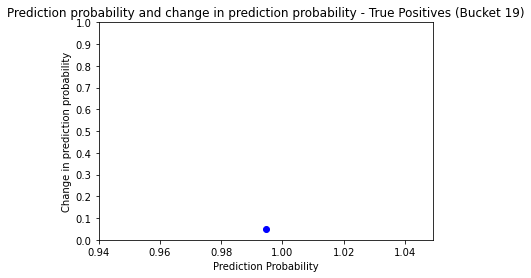

Category 3 of 4. Instance 1 of 1
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

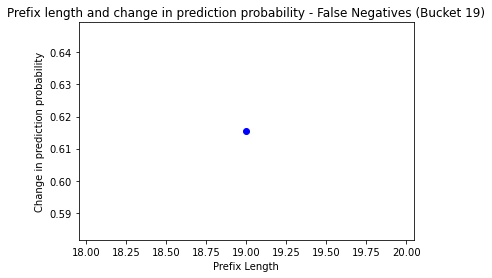

Category 4 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

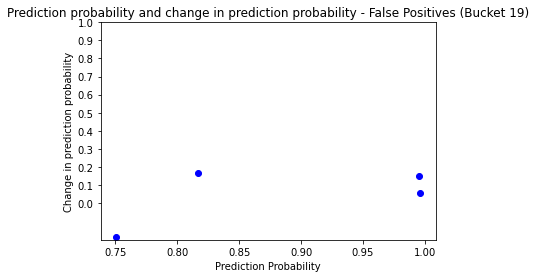

Bucket 20
Category 1 of 4. Instance 1 of 8
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

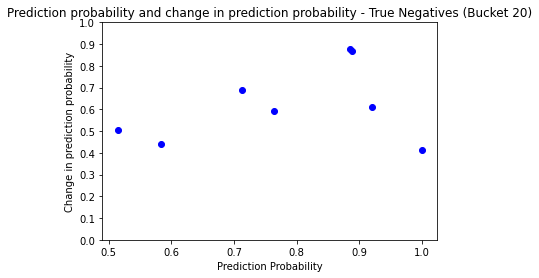

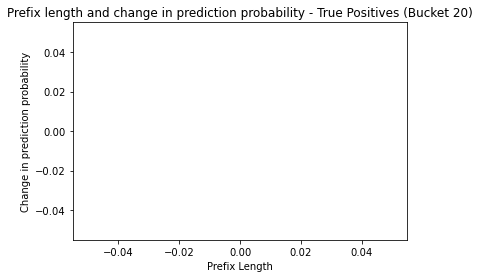

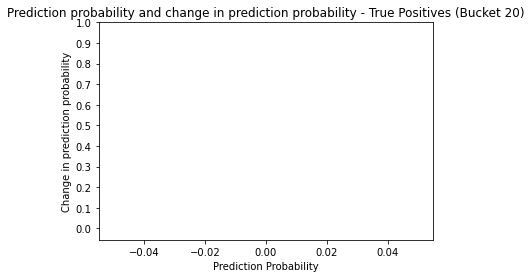

Category 3 of 4. Instance 1 of 2
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

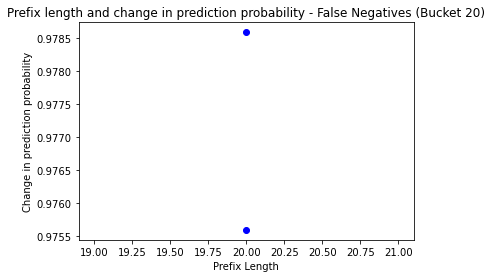

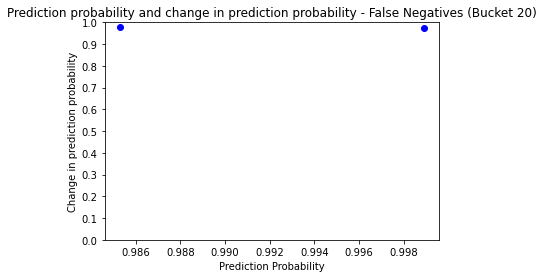

Category 4 of 4. Instance 1 of 4
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distri

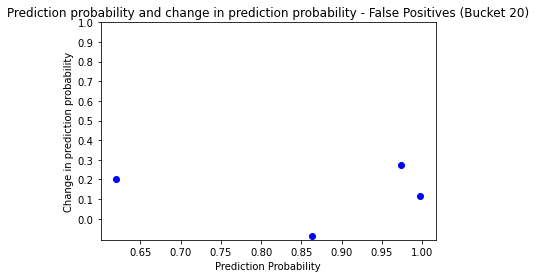

In [13]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

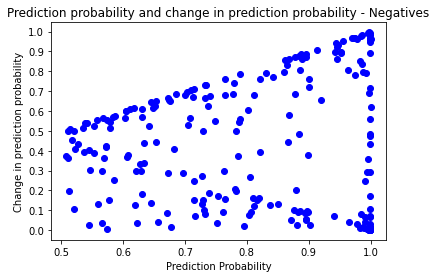

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [16]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

LIME Fidelity Score: 0.26760319083766543 
SHAP Fidelity Score: 0.30908973329393175


In [17]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

Positive predictions: 
LIME Fidelity Score: 0.4413069119515546 
SHAP Fidelity Score: 0.41066237926487864
Negative predictions: 
LIME Fidelity Score: 0.3401279499584978 
SHAP Fidelity Score: 0.45889858711849557
